In the first cell below we import all the required librarries for this code, the main ones being Pytorch, transformers, PIL, Scikit-learn, numpy, pandas, matplotlib and seaborn and a few other utlities and smaller packages. Depending on how recent the model called from Hugging Face is you may need to take care with the interplay between Python versions, Transformers versions and Pytorch  

In [1]:

# Standard library
import os




#Code to login to Hugging Face with your token
from huggingface_hub import login
login()



#Setting envirnoment variables for good notebook behaviour
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"





# PyTorch & ML
import torch
from torchvision import datasets, transforms, models

from transformers import AutoImageProcessor, AutoModel, DefaultDataCollator
from torch.utils.data import Dataset, DataLoader

# Utilities
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import h5py
import json
from IPython.display import display, HTML
from collections import Counter
from scipy.stats import mode
from sklearn.preprocessing import Normalizer


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance

# ML tools
from sklearn.preprocessing import normalize

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    f1_score,                # macro, weighted
    precision_score,         # macro, weighted
    recall_score,            # macro, weighted
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)



from sklearn.model_selection import cross_val_predict

#Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

import hdbscan
from sklearn.utils import resample

from sklearn.metrics import (
    adjusted_rand_score,            # ARI
    adjusted_mutual_info_score,     # AMI
    normalized_mutual_info_score,   # NMI
    davies_bouldin_score,  # compactness & separation
    silhouette_score
)



#Dimension Reduction
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Feature Vector Statistics
from sklearn.covariance import LedoitWolf
from sklearn.metrics import pairwise_distances
from scipy.spatial import ConvexHull

from scipy.spatial.distance import pdist, cdist



# Check if LaTeX is installed and available
try:
    plt.rc('text', usetex=True)
    # You can also specify the font family to match your LaTeX document
    plt.rc('font', family='serif')
    # A common font family is Computer Modern, which is the default for LaTeX.
    plt.rc('font', serif='Computer Modern')
except RuntimeError:
    print("Warning: LaTeX is not installed. Using default Matplotlib fonts.")
    # Fallback to a non-LaTeX font if an error occurs
    plt.rc('font', family='serif')
    plt.rc('font', serif='DejaVu Serif')




Code which performs the feature extraction in batch for speed and converts images to feature vectors. A simple non-batched way to do this can be found on Hugging Face Tutorials


In [2]:
class PreprocessedImageDataset(Dataset):
    """
    Torch Dataset that loads images from an ImageFolder structure,
    validates them, and applies a Hugging Face image preprocessor.
    Returns (inputs_dict, label).
    """
    def __init__(self, root_folder, preprocessor):
        self.dataset = datasets.ImageFolder(root_folder)
        self.preprocessor = preprocessor

        # Validate images
        valid_samples = []
        for path, label in tqdm(self.dataset.samples, desc="Validating images"):
            try:
                with Image.open(path) as img:
                    img.verify()
                valid_samples.append((path, label))
            except (OSError, ValueError):
                print(f"Skipping {path}: not a valid image.")
        self.dataset.samples = valid_samples
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = Image.open(path).convert("RGB")
        inputs = self.preprocessor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label


def extract_features_batch(image_folder_path, model, preprocessor, device, batch_size=32):
    """
    Extract features in batches from an image folder using a Hugging Face model.

    Returns:
    tuple:
        - numpy.ndarray: Extracted feature matrix [num_images, feature_dim], in same order as file_paths.
        - numpy.ndarray: True labels (class indices).
        - list: File paths of processed images (aligned with features/labels).
        - list: Class names from ImageFolder.

    """
    model.eval()
    dataset = PreprocessedImageDataset(image_folder_path, preprocessor)
    class_names = dataset.dataset.classes
    file_paths = [s[0] for s in dataset.dataset.samples]

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False, #Do not shuffule so that you can trace back features to orginal file names
        num_workers=0  # required in notebooks to avoid multiprocessing crashes
    )
    
    all_features, all_labels = [], []

    with torch.inference_mode():
        for batch_inputs, labels in tqdm(dataloader, desc="Processing batches"):
            batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
            outputs = model(**batch_inputs)

            if hasattr(outputs, "pooler_output") and outputs.pooler_output is not None:
                features = outputs.pooler_output
            elif hasattr(outputs, "last_hidden_state"):
                features = outputs.last_hidden_state[:, 0, :]  # CLS token
            else:
                raise ValueError("Model outputs do not contain expected features.")

            all_features.append(features.float().cpu().numpy())
            all_labels.append(labels.cpu().numpy().astype(np.int64))

    final_features = np.concatenate(all_features, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)

    print("Feature extraction complete.")
    return final_features, final_labels, file_paths, class_names


Code which loads the preprocessor and model required for image feature extraction. 

In [3]:



def load_model_and_preprocessor(model_id):
    """
    Load a Hugging Face model and image processor with device selection.
    
    Device selection priority:
    1. CUDA (NVIDIA GPU, with bfloat16 if supported)
    2. MPS (Apple Silicon GPU, with bfloat16 support)
    3. CPU (float32 fallback)

    Returns:
        model (torch.nn.Module): Hugging Face model on selected device, set to eval mode.
        device (str): 'cuda', 'mps', or 'cpu'.
        preprocessor (transformers.ImageProcessor): Corresponding image preprocessor.

    Note:
        Use `torch.inference_mode()` during inference/feature extraction 
        for optimal performance and memory efficiency:
        
        >>> model, device, preprocessor = load_model_and_preprocessor("google/vit-base-patch16-224")
        >>> with torch.inference_mode():
        ...     outputs = model(**inputs)
    """
    if torch.cuda.is_available():
        device = "cuda"
        dtype = torch.bfloat16 
    elif torch.backends.mps.is_available():
        device = "mps"
        dtype = torch.bfloat16  # supported on modern MPS backends
    else:
        device = "cpu"
        dtype = torch.float32

    try:
        # Load backbone model (for classification tasks, consider AutoModelForImageClassification)
        model = AutoModel.from_pretrained(
            model_id,
            attn_implementation="sdpa",
            dtype=dtype
        ).to(device)

        preprocessor = AutoImageProcessor.from_pretrained(model_id)
        
        print(f"Model and preprocessor loaded successfully on device: {device} (dtype={dtype})")
    except Exception as e:
        raise ValueError(f"Could not load Hugging Face model or preprocessor for '{model_id}': {e}")
    
    # Ensure deterministic behavior (disable dropout, etc.)
    model.eval()
    return model, device, preprocessor


Setup the image folder and the data saving locations. 

In [4]:

import os
from pathlib import Path
import re


# ----------------------------
# Run / save configuration
# ----------------------------
subject_name = "diverse_paper_oct"

# ----------------------------
# Literature best results per dataset
# ----------------------------
literature_best = {
    "Fossil Tracks": 0.8600,
    "Pollen": 0.9786,
    "Diverse Fossils": 0.8297,
    "Radiolarians": 0.8846,
    "Endless Forams Original": 0.8740
}

# ----------------------------
# Dataset selection
# ----------------------------
dataset_name = "Diverse Fossils"
if dataset_name not in literature_best:
    raise ValueError(f"{dataset_name} not found in literature_best keys.")

# ----------------------------
# Paths
# ----------------------------
image_folder_path = '/Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils'

# ----------------------------
# Model configuration
# ----------------------------
model_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"
model_id_clean = model_id.replace("/", "_")

# ----------------------------
# Save folder
# ----------------------------
folder_name = re.sub(r"[^a-zA-Z0-9_\-]", "_", f"{subject_name}_{model_id_clean}")
save_loc = Path.cwd() / folder_name
save_loc.mkdir(parents=True, exist_ok=True)


Code to load you model and do the feature extraction

In [5]:


# ----------------------------
# Load model and preprocessor
# ----------------------------
# Will download the model if this is your first time
model, device, preprocessor = load_model_and_preprocessor(model_id=model_id)

# ----------------------------
# Extract features
# ----------------------------
# features are returned in the same order as file paths
features, true_labels, file_paths, class_names = extract_features_batch(
    image_folder_path,
    model,
    preprocessor,
    device,
    batch_size=64
)

print("Extracted features shape:", features.shape)





# ----------------------------
# check
# ----------------------------
assert features.shape[0] == len(true_labels) == len(file_paths), "Mismatch in features, labels, or file paths"

# ----------------------------
# Clean class names for plotting
# ----------------------------
class_names = [s.replace('_', ' ').capitalize() for s in class_names]

print("Classes:", class_names)

num_classes = len(class_names)




Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model and preprocessor loaded successfully on device: mps (dtype=torch.bfloat16)


Validating images:   0%|          | 0/59253 [00:00<?, ?it/s]

Skipping /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils/agnatha/1_122.tunicate_larva.jpg: not a valid image.
Skipping /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils/agnatha/1_16.350px-osteostraci_janvier.jpg: not a valid image.
Skipping /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils/agnatha/1_270.acanthodian.jpg: not a valid image.
Skipping /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils/agnatha/1_286.i0289-0003-25-10-1045-f04.jpg: not a valid image.
Skipping /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils/agnatha/1_50.350px-thelodonti.jpg: not a vali

Processing batches:   0%|          | 0/926 [00:00<?, ?it/s]

The channel dimension is ambiguous. Got image shape torch.Size([3, 1, 1]). Assuming channels are the first dimension. Use the [input_data_format](https://huggingface.co/docs/transformers/main/internal/image_processing_utils#transformers.image_transforms.rescale.input_data_format) parameter to assign the channel dimension.


Feature extraction complete.
Extracted features shape: (59244, 1024)
Classes: ['Agnatha', 'Ammonoid', 'Amphibian', 'Angiosperm', 'Avialae', 'Belemnite', 'Bivalve', 'Blastoid', 'Bone fragment', 'Brachiopod', 'Bryozoan', 'Chelicerate', 'Chondrichthyes', 'Conodont', 'Coral', 'Crinoid', 'Crocodylomorph', 'Crustacean', 'Echinoid', 'Foraminifer', 'Gastropod', 'Graptolite', 'Gymnosperm', 'Insect', 'Mammal', 'Mammal teeth', 'Marine reptile', 'Myriapod', 'Nautiloid', 'Ophiuroid', 'Ornithischian', 'Osteichthyes', 'Ostracod', 'Petrified wood', 'Placoderms', 'Pteridophyte', 'Pterosaurs', 'Radiolarian', 'Reptile teeth', 'Sauropodomorph', 'Shark teeth', 'Snake', 'Sponge', 'Spore or pollen', 'Starfish', 'Stromatolite', 'Theropod', 'Trace fossil', 'Trilobite', 'Turtle']


In [6]:


#Code which saves feature vectors to file, can modify if you want train and test separtely modify for the different data pipelines





# ----------------------------
# Save feature vectors and labels
# ----------------------------
h5_path = os.path.join(save_loc, "feature_vectors_labels.h5")

with h5py.File(h5_path, "w") as f:
    # Main datasets
    f.create_dataset("features", data=features, compression="gzip", compression_opts=4)
    f.create_dataset("true_labels", data=true_labels, compression="gzip", compression_opts=4)

    # Metadata stored as JSON strings
    f.attrs["class_names"] = json.dumps(class_names)
    f.attrs["file_paths"] = json.dumps(file_paths)  

print(f"Features and labels saved to {h5_path}")






    

Features and labels saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/feature_vectors_labels.h5


Optional Code to laod features from saved location rather than rerun runing inference to save compute

In [7]:


"""
#Code to load feature vectors and labels from file if this is neaded


data_path = '/Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Pipeline_done_diverse_fossils_set_facebook_dinov3-vitl16-pretrain-lvd1689m/feature_vectors_labels.h5'


with h5py.File(data_path, "r") as f:

    # Load feature matrix
    features = f["features"][:]
    
    # Load true labels
    true_labels = f["true_labels"][:]

        
    #Load the MetaData
    class_names = json.loads(f.attrs["class_names"])
    file_paths= json.loads(f.attrs["file_paths"])



assert features.shape[0] == len(true_labels) == len(file_paths), "Mismatch in loaded features, labels, or file paths"
"""




'\n#Code to load feature vectors and labels from file if this is neaded\n\n\ndata_path = \'/Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Pipeline_done_diverse_fossils_set_facebook_dinov3-vitl16-pretrain-lvd1689m/feature_vectors_labels.h5\'\n\n\nwith h5py.File(data_path, "r") as f:\n\n    # Load feature matrix\n    features = f["features"][:]\n\n    # Load true labels\n    true_labels = f["true_labels"][:]\n\n\n    #Load the MetaData\n    class_names = json.loads(f.attrs["class_names"])\n    file_paths= json.loads(f.attrs["file_paths"])\n\n\n\nassert features.shape[0] == len(true_labels) == len(file_paths), "Mismatch in loaded features, labels, or file paths"\n'

In [8]:

#Also created normalised features which are needed for some steps 

# ----------------------------
norm_features = normalize(features, norm='l2', axis=1) 
# ----------------------------






FEATURE VECTOR VISUALIATION 

Below we plot several ways to visualise the feature vectors which are extracted using dimension reduction. 




Performing PCA for 2D visualization...
Explained variance ratio (PC1, PC2): [0.06862025 0.06358436]


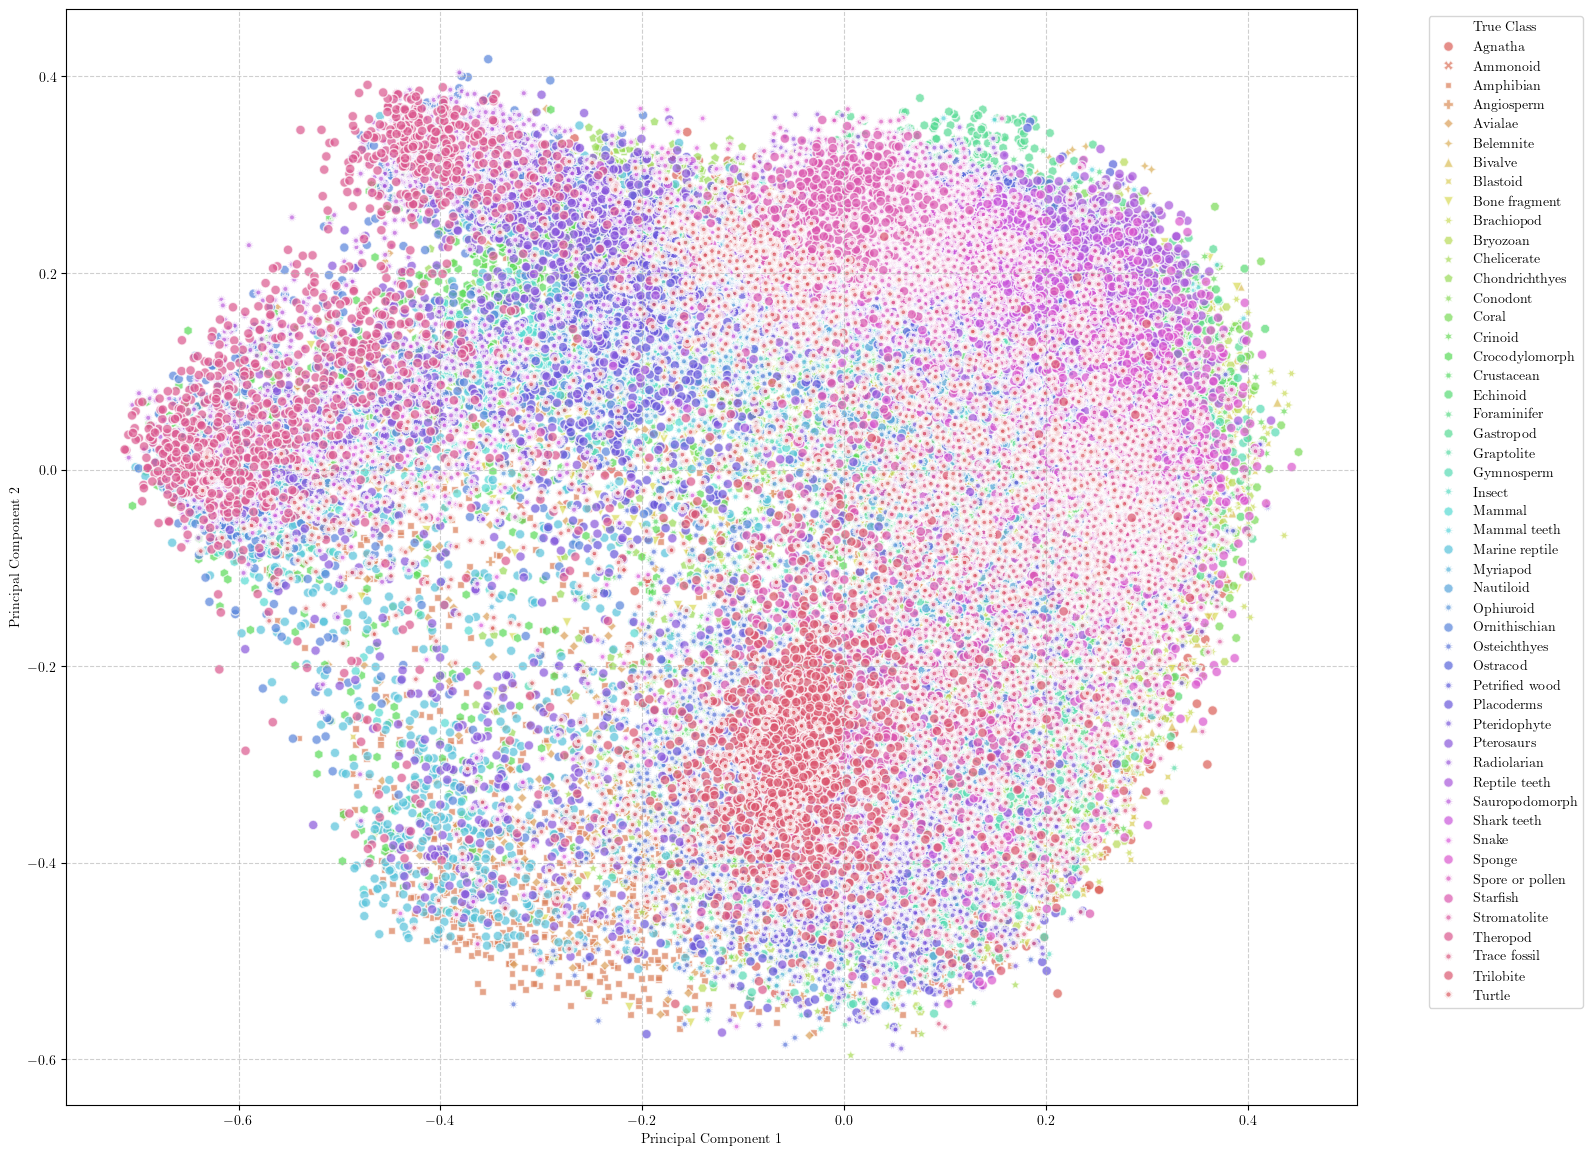

PCA plot saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/PCA.pdf


In [9]:
def plot_pca_features_by_class(features, true_labels, class_names, title="PCA of Features by True Class"):
    """
    Performs PCA on features to 2 dimensions and plots them,
    coloring points by their true class labels.

    Args:
        features (numpy.ndarray): Extracted features.
        true_labels (numpy.ndarray): Ground truth labels.
        class_names (list): List of class names.
        title (str): Plot title.
    """
    if features.shape[0] == 0:
        print("No features to plot for PCA.")
        return

    print("\nPerforming PCA for 2D visualization...")
    
    # Map integer labels to class names once
    label_names = [class_names[label] for label in true_labels]

    # Perform PCA
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features)
    print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

    plt.figure(figsize=(16, 12))
    sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=label_names,
        palette='hls',
        s=50,
        alpha=0.7,
        style = label_names, linewidth=1.0
    )

    #plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='True Class', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()

    # Save plot
    output_path = os.path.join(save_loc, "PCA.pdf")
    plt.savefig(output_path, dpi=500, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"PCA plot saved to {output_path}")

# Call the function
plot_pca_features_by_class(norm_features, true_labels, class_names, title="PCA of Feature Vectors")



Performing t-SNE for 2D visualization (perplexity=20, learning_rate=200)...


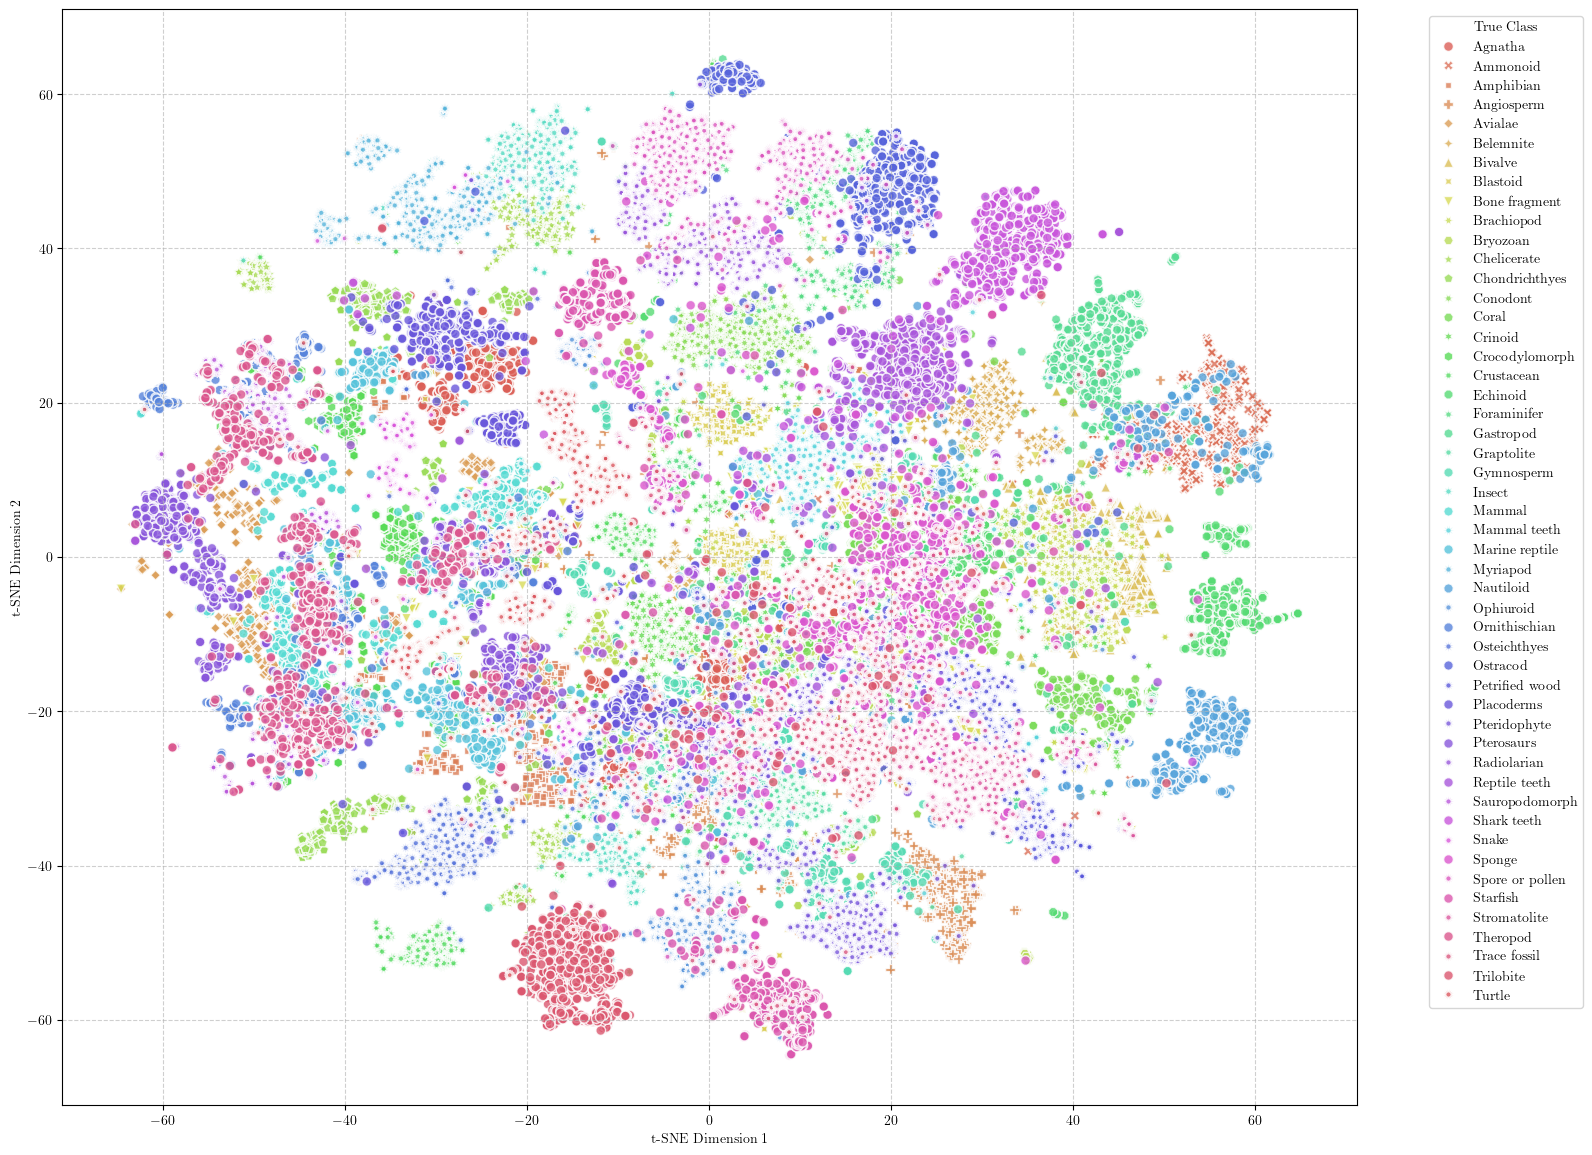

In [10]:



def plot_tsne_features_by_class(features, true_labels, class_names, title="t-SNE of Features by True Class",
                                 perplexity=30, learning_rate=200):
    """
    Performs t-SNE dimensionality reduction to 2 dimensions and plots them,
    coloring points by their true class labels.

    Args:
        features (numpy.ndarray): The extracted features.
        true_labels (numpy.ndarray): The ground truth labels for the features.
        class_names (list): List of string names for each class.
        title (str): Title for the plot.
        perplexity (float): t-SNE parameter. Roughly, the number of nearest neighbors
                            that is taken into account. Affects the balance between
                            local and global aspects of the data. Typical values are
                            between 5 and 50.
        learning_rate (float): t-SNE parameter. Also known as epsilon. If too high,
                               points can clump together. If too low, points can be
                               too scattered.
    """
    if features.shape[0] == 0 or len(np.unique(true_labels)) < 1:
        print("Not enough features or unique classes to plot t-SNE by true class.")
        return

    print(f"\nPerforming t-SNE for 2D visualization (perplexity={perplexity}, learning_rate={learning_rate})...")
    # Initialize t-SNE model
    # n_components=2 for 2D visualization
    # random_state for reproducibility
    # perplexity and learning_rate are important hyperparameters for t-SNE
    # n_jobs=-1 uses all available CPU cores for faster computation (if supported)
    reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=42, n_jobs=-1, metric='cosine')
    features_2d = reducer.fit_transform(features)

    plt.figure(figsize=(16, 12))

    # Map integer labels to class names once
    label_names = [class_names[label] for label in true_labels]
    
 

    sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue= label_names ,
        palette='hls', # Using the dynamically selected palette
        s=50, # Marker size
        alpha=0.8,
        style= label_names, linewidth=1.0)
   
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.6)


    #Save and show 
    plt.legend(title='True Class', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(save_loc, "t-SNE.pdf"), dpi = 500, bbox_inches='tight')
    plt.show() 
    plt.close()


plot_tsne_features_by_class(norm_features, true_labels, class_names,
                             
                             perplexity=20, # Common starting point, adjust as needed (5 to 50)
                            learning_rate=200)




Performing UMAP for 2D visualization (n_neighbors=30, min_dist=0.1)...


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


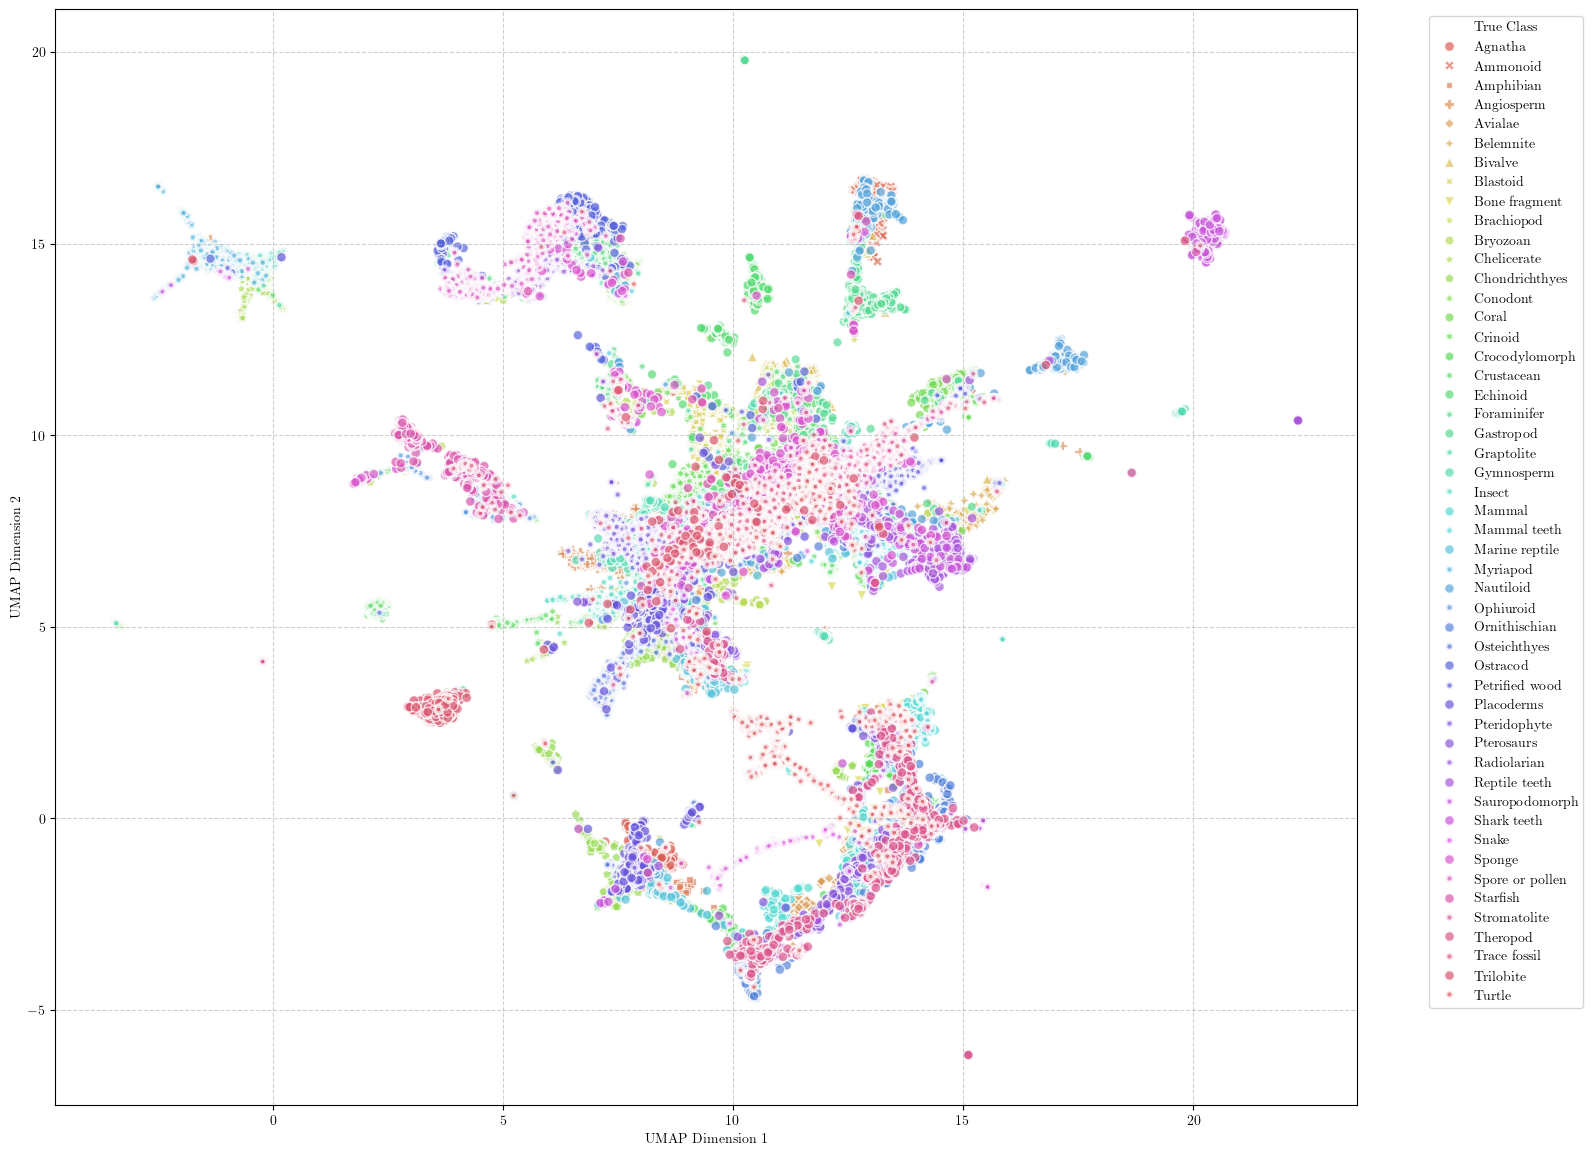

In [11]:


def plot_umap_features_by_class(features, true_labels, class_names, title="UMAP of Features by True Class",
                                 n_neighbors=15, min_dist=0.1):
    """
    Performs UMAP dimensionality reduction to 2 dimensions and plots them,
    coloring points by their true class labels.

    Args:
        features (numpy.ndarray): The extracted features.
        true_labels (numpy.ndarray): The ground truth labels for the features.
        class_names (list): List of string names for each class.
        title (str): Title for the plot.
        n_neighbors (int): UMAP parameter. The size of local neighborhood (in terms of number of neighboring points)
                           used for manifold approximation. Larger values preserve more global structure.
        min_dist (float): UMAP parameter. The effective minimum distance between embedded points.
                          Smaller values allow points to be clustered more tightly.
    """
    if features.shape[0] == 0 or len(np.unique(true_labels)) < 1:
        print("Not enough features or unique classes to plot UMAP by true class.")
        return

    print(f"\nPerforming UMAP for 2D visualization (n_neighbors={n_neighbors}, min_dist={min_dist})...")
    # Initialize UMAP model
    # n_components=2 for 2D visualization
    # random_state for reproducibility
    # n_neighbors and min_dist are important hyperparameters for UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, metric='cosine')
    features_2d = reducer.fit_transform(features)


    # Map integer labels to class names once
    label_names = [class_names[label] for label in true_labels]
    
    

    plt.figure(figsize=(16, 12))
    sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue= label_names,
        palette="hls", 
        s=50, # Marker size
        alpha=0.7,
        style= label_names, linewidth=1.0
        #legend=False
    )
    
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='True Class', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    #Save and show 
    plt.tight_layout()
    plt.savefig(os.path.join(save_loc, "UMAP.pdf"), dpi = 500, bbox_inches='tight')
    plt.show()
    plt.close()



plot_umap_features_by_class(norm_features, true_labels, class_names,
                                        n_neighbors=30, # Adjust as needed for your data
                                        min_dist=0.1)





SUPERVISED LEARNING- Cross-Validation







In [12]:
%%time




# ----------------------------
# Classifiers
# ----------------------------
classifiers = {
    "k-Nearest Neighbours": Pipeline([
        ("normalize", Normalizer(norm='l2')),
        ("knn", KNeighborsClassifier(n_neighbors=5, metric='cosine'))
    ]),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
}







# ----------------------------
# Fold generator
# ----------------------------
def generate_folds(X, y, max_splits=5, fallback_test_size=0.2, random_state=None, repeat_fallback=5):
    """
    Generate train/validation indices for cross-validation.
    - If every class has at least `max_splits` samples, use StratifiedKFold(n_splits=max_splits).
    - Otherwise, attempt StratifiedShuffleSplit(n_splits=repeat_fallback).
      If stratified repeated splitting is impossible (very small classes), fall back to ShuffleSplit.
    Returns:
        folds: list of (train_idx, val_idx) numpy index arrays (indices refer to the arrays passed into this function)
    """
    y = np.asarray(y)
    n_samples = len(y)
    unique, counts = np.unique(y, return_counts=True)
    min_class_count = counts.min()
    folds = []
    indices = np.arange(n_samples)

    if min_class_count >= max_splits:
        # Use standard stratified k-fold with exactly max_splits
        skf = StratifiedKFold(n_splits=max_splits, shuffle=True, random_state=random_state)
        # skf.split accepts X-like and y; using indices is fine (we only need consistent lengths)
        for train_idx, val_idx in skf.split(indices, y):
            folds.append((train_idx, val_idx))
    else:
        # Try to get repeated stratified splits. If impossible (ValueError), fall back to unstratified ShuffleSplit.
        try:
            sss = StratifiedShuffleSplit(n_splits=repeat_fallback, test_size=fallback_test_size, random_state=random_state)
            for train_idx, val_idx in sss.split(indices, y):
                folds.append((train_idx, val_idx))
        except ValueError:
            # Stratified repeated splits failed (very small class counts). Fall back to unstratified repeated splits.
            ss = ShuffleSplit(n_splits=repeat_fallback, test_size=fallback_test_size, random_state=random_state)
            for train_idx, val_idx in ss.split(indices):
                folds.append((train_idx, val_idx))

    return folds

# ----------------------------
# Top-k accuracy
# ----------------------------
def calculate_top_k_accuracy(y_true, y_probas, k=1, classes=None, fallback=np.nan):
    if classes is None:
        raise ValueError("Provide the classifier's classes array to match label indices.")

    n_classes = y_probas.shape[1]
    if k >= n_classes:
        return fallback

    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    y_true_idx = np.array([class_to_idx.get(lbl, -1) for lbl in y_true])
    valid_mask = y_true_idx != -1
    if not np.any(valid_mask):
        return fallback

    top_k_preds = np.argpartition(y_probas, -k, axis=1)[:, -k:]
    correct = np.any(top_k_preds[valid_mask] == y_true_idx[valid_mask][:, None], axis=1)
    return np.mean(correct)

# ----------------------------
# Settings
# ----------------------------
train_sizes = [0.1, 0.3, 0.5, 0.7, 1]
n_repeats = 10
max_splits = 5
all_results = []




# ----------------------------
# Outer loop: train fraction
# ----------------------------
for train_fraction in tqdm(train_sizes, desc="Train fractions"):
    

    n_samples_needed = int(np.ceil(train_fraction * len(true_labels)))
    n_classes = len(np.unique(true_labels))
    if train_fraction < 1.0 and n_samples_needed < n_classes:
        print(f"Skipping: only {n_samples_needed} samples, but {n_classes} classes.")
        continue

    for repeat_idx in tqdm(range(n_repeats), desc=f"Repeats for train fraction {train_fraction:.2f}", leave=False):
        # Subsample if train_fraction < 1.0
        if train_fraction < 1.0:
            sampled_features, _, sampled_labels, _ = train_test_split(
                features, true_labels,
                train_size=train_fraction,
                stratify=true_labels,
                random_state=42 + repeat_idx,
                shuffle=True
            )
        else:
            sampled_features = np.array(features)
            sampled_labels = np.array(true_labels)
        
        # Generate folds (K-fold or repeated fallback)
        folds = generate_folds(
            sampled_features,
            sampled_labels,
            max_splits= max_splits,
            fallback_test_size=0.2,
            random_state=42 + repeat_idx,
            repeat_fallback= max_splits 
        )

        # ----------------------------
        # Inner loop: classifiers
        # ----------------------------
        for clf_name, clf in tqdm(classifiers.items(), desc="Classifiers", leave=False):
            #print(f"  Repeat {repeat_idx+1}/{n_repeats} — Classifier: {clf_name}")
            fold_top1, fold_top2, fold_top3 = [], [], []
            fold_f1_macro, fold_f1_weighted = [], []
            fold_precision_macro, fold_recall_macro = [], []
            fold_specificity_macro, fold_bal_acc = [], []
            used_folds = 0

            for train_idx, val_idx in tqdm(folds, desc=f"Folds ({clf_name})", leave=False):
                X_train, X_val = sampled_features[train_idx], sampled_features[val_idx]
                y_train, y_val = sampled_labels[train_idx], sampled_labels[val_idx]

                if len(np.unique(y_train)) < n_classes:
                    continue

                clf.fit(X_train, y_train)

                # ----------------------------
                # Metrics
                # ----------------------------
                if hasattr(clf, "predict_proba"):
                    y_probas = clf.predict_proba(X_val)
                    y_pred = clf.classes_[np.argmax(y_probas, axis=1)]
                    top1 = calculate_top_k_accuracy(y_val, y_probas, k=1, classes=clf.classes_)
                    top2 = calculate_top_k_accuracy(y_val, y_probas, k=2, classes=clf.classes_)
                    top3 = calculate_top_k_accuracy(y_val, y_probas, k=3, classes=clf.classes_)
                else:
                    y_pred = clf.predict(X_val)
                    top1 = accuracy_score(y_val, y_pred)
                    top2 = np.nan
                    top3 = np.nan

                f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
                f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
                precision_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
                recall_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)

                labels_for_cm = getattr(clf, "classes_", np.unique(np.concatenate([y_train, y_val])))
                cm = confusion_matrix(y_val, y_pred, labels=labels_for_cm)
                total = cm.sum()
                row_sum = cm.sum(axis=1)
                col_sum = cm.sum(axis=0)
                diag = np.diag(cm)
                tn = total - (row_sum + col_sum - diag)
                fp = col_sum - diag
                with np.errstate(divide='ignore', invalid='ignore'):
                    specificity_per_class = np.divide(tn, tn + fp, where=(tn + fp) > 0)
                specificity_macro = np.nanmean(specificity_per_class)
                balanced_acc = balanced_accuracy_score(y_val, y_pred)

                # ----------------------------
                # Record each fold individually
                # ----------------------------
                all_results.append({
                    "train_fraction": train_fraction,
                    "repeat": repeat_idx,
                    "classifier": clf_name,
                    "top1_accuracy": top1,
                    "top2_accuracy": top2,
                    "top3_accuracy": top3,
                    "f1_macro": f1_macro,
                    "f1_weighted": f1_weighted,
                    "precision_macro": precision_macro,
                    "recall_macro": recall_macro,
                    "specificity_macro": specificity_macro,
                    "balanced_accuracy": balanced_acc
                })

# ----------------------------
# Aggregate and save results
# ----------------------------




pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 150)         # prevent wrapping
pd.set_option('display.float_format', '{:.4f}'.format)


latex_file_path = os.path.join(save_loc, "classification_cv_results.tex")



def display_scrollable_df(df):
    display(HTML(df.to_html(notebook=True, max_rows=50).replace(
        '<table border="1" class="dataframe">',
        '<table border="1" class="dataframe" style="display:block;overflow-x:auto;white-space:nowrap;">'
    )))

# Keep raw fold-level results
results_df = pd.DataFrame(all_results)

# Aggregate fold-level results
agg_df = results_df.groupby(['train_fraction', 'classifier']).agg(
    n_folds_used=('top1_accuracy', 'count'),
    mean_top1_accuracy=('top1_accuracy', 'mean'),
    std_top1_accuracy=('top1_accuracy', 'std'),
    mean_top2_accuracy=('top2_accuracy', 'mean'),
    std_top2_accuracy=('top2_accuracy', 'std'),
    mean_top3_accuracy=('top3_accuracy', 'mean'),
    std_top3_accuracy=('top3_accuracy', 'std'),
    mean_f1_macro=('f1_macro', 'mean'),
    std_f1_macro=('f1_macro', 'std'),
    mean_f1_weighted=('f1_weighted', 'mean'),
    std_f1_weighted=('f1_weighted', 'std'),
    mean_precision_macro=('precision_macro', 'mean'),
    std_precision_macro=('precision_macro', 'std'),
    mean_recall_macro=('recall_macro', 'mean'),
    std_recall_macro=('recall_macro', 'std'),
    mean_specificity_macro=('specificity_macro', 'mean'),
    std_specificity_macro=('specificity_macro', 'std'),
    mean_balanced_accuracy=('balanced_accuracy', 'mean'),
    std_balanced_accuracy=('balanced_accuracy', 'std')
).reset_index()

# Save CSV of aggregated results
agg_df.to_csv(os.path.join(save_loc, "classification_cv_results.csv"), index=False)
print("\nSaved cross-validation results to classification_cv_results.csv")

# Use `agg_df` for LaTeX
latex_df = agg_df.copy()


def fmt_mean_std(mean, std):
    if np.isnan(mean):
        return "N/A"
    if np.isnan(std):
        return f"{mean:.3f}"
    return f"{mean:.3f} ± {std:.3f}"

latex_formatted = pd.DataFrame({
    "Train Fraction": latex_df["train_fraction"].apply(lambda x: f"{float(x):.2f}"),
    "Classifier": latex_df["classifier"],
    "Top-1 Accuracy": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_top1_accuracy"], latex_df["std_top1_accuracy"])],
    "Top-2 Accuracy": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_top2_accuracy"], latex_df["std_top2_accuracy"])],
    "Top-3 Accuracy": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_top3_accuracy"], latex_df["std_top3_accuracy"])],
    "F1 Macro": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_f1_macro"], latex_df["std_f1_macro"])],
    "F1 Weighted": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_f1_weighted"], latex_df["std_f1_weighted"])],
    "Precision Macro": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_precision_macro"], latex_df["std_precision_macro"])],
    "Recall Macro": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_recall_macro"], latex_df["std_recall_macro"])],
    "Specificity Macro": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_specificity_macro"], latex_df["std_specificity_macro"])],
    "Balanced Accuracy": [fmt_mean_std(m, s) for m, s in zip(latex_df["mean_balanced_accuracy"], latex_df["std_balanced_accuracy"])]
})

# Optional: bold max per metric
numeric_cols = [
    "Top-1 Accuracy", "Top-2 Accuracy", "Top-3 Accuracy",
    "F1 Macro", "F1 Weighted", "Precision Macro",
    "Recall Macro", "Specificity Macro", "Balanced Accuracy"
]

def extract_mean(val):
    try:
        return float(val.split("±")[0].strip())
    except:
        return -np.inf

bolded_df = latex_formatted.copy()
for col in numeric_cols:
    means = latex_formatted[col].apply(extract_mean)
    valid_means = means.replace([-np.inf, np.inf], np.nan).dropna()
    if valid_means.empty:
        continue
    max_idx = valid_means.idxmax()
    bolded_df.at[max_idx, col] = r"\textbf{" + bolded_df.at[max_idx, col] + "}"

# Export LaTeX
table_body = bolded_df.to_latex(index=False, escape=False)
table_lines = table_body.splitlines()
core_table = "\n".join(table_lines[2:-1])

n_cols = bolded_df.shape[1]
col_spec = "l" + "X" * (n_cols - 1)

latex_content = rf"""
\begin{{table}}[ht]
\centering
\tiny
\caption{{Classification results with mean $\pm$ standard deviation over folds}}
\label{{tab:classification_results}}
\begin{{tabularx}}{{\textwidth}}{{{col_spec}}}
\toprule
{core_table}
\bottomrule
\end{{tabularx}}
\end{{table}}
"""

with open(latex_file_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"LaTeX table saved to {latex_file_path}")

display_scrollable_df(latex_df)


Train fractions:   0%|          | 0/5 [00:00<?, ?it/s]

Repeats for train fraction 0.10:   0%|          | 0/10 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Repeats for train fraction 0.30:   0%|          | 0/10 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Repeats for train fraction 0.50:   0%|          | 0/10 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Repeats for train fraction 0.70:   0%|          | 0/10 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Repeats for train fraction 1.00:   0%|          | 0/10 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]

Classifiers:   0%|          | 0/2 [00:00<?, ?it/s]

Folds (k-Nearest Neighbours):   0%|          | 0/5 [00:00<?, ?it/s]

Folds (Logistic Regression):   0%|          | 0/5 [00:00<?, ?it/s]


Saved cross-validation results to classification_cv_results.csv
LaTeX table saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/classification_cv_results.tex


CPU times: user 1h 47min 2s, sys: 2min 1s, total: 1h 49min 3s
Wall time: 11h 53min 44s


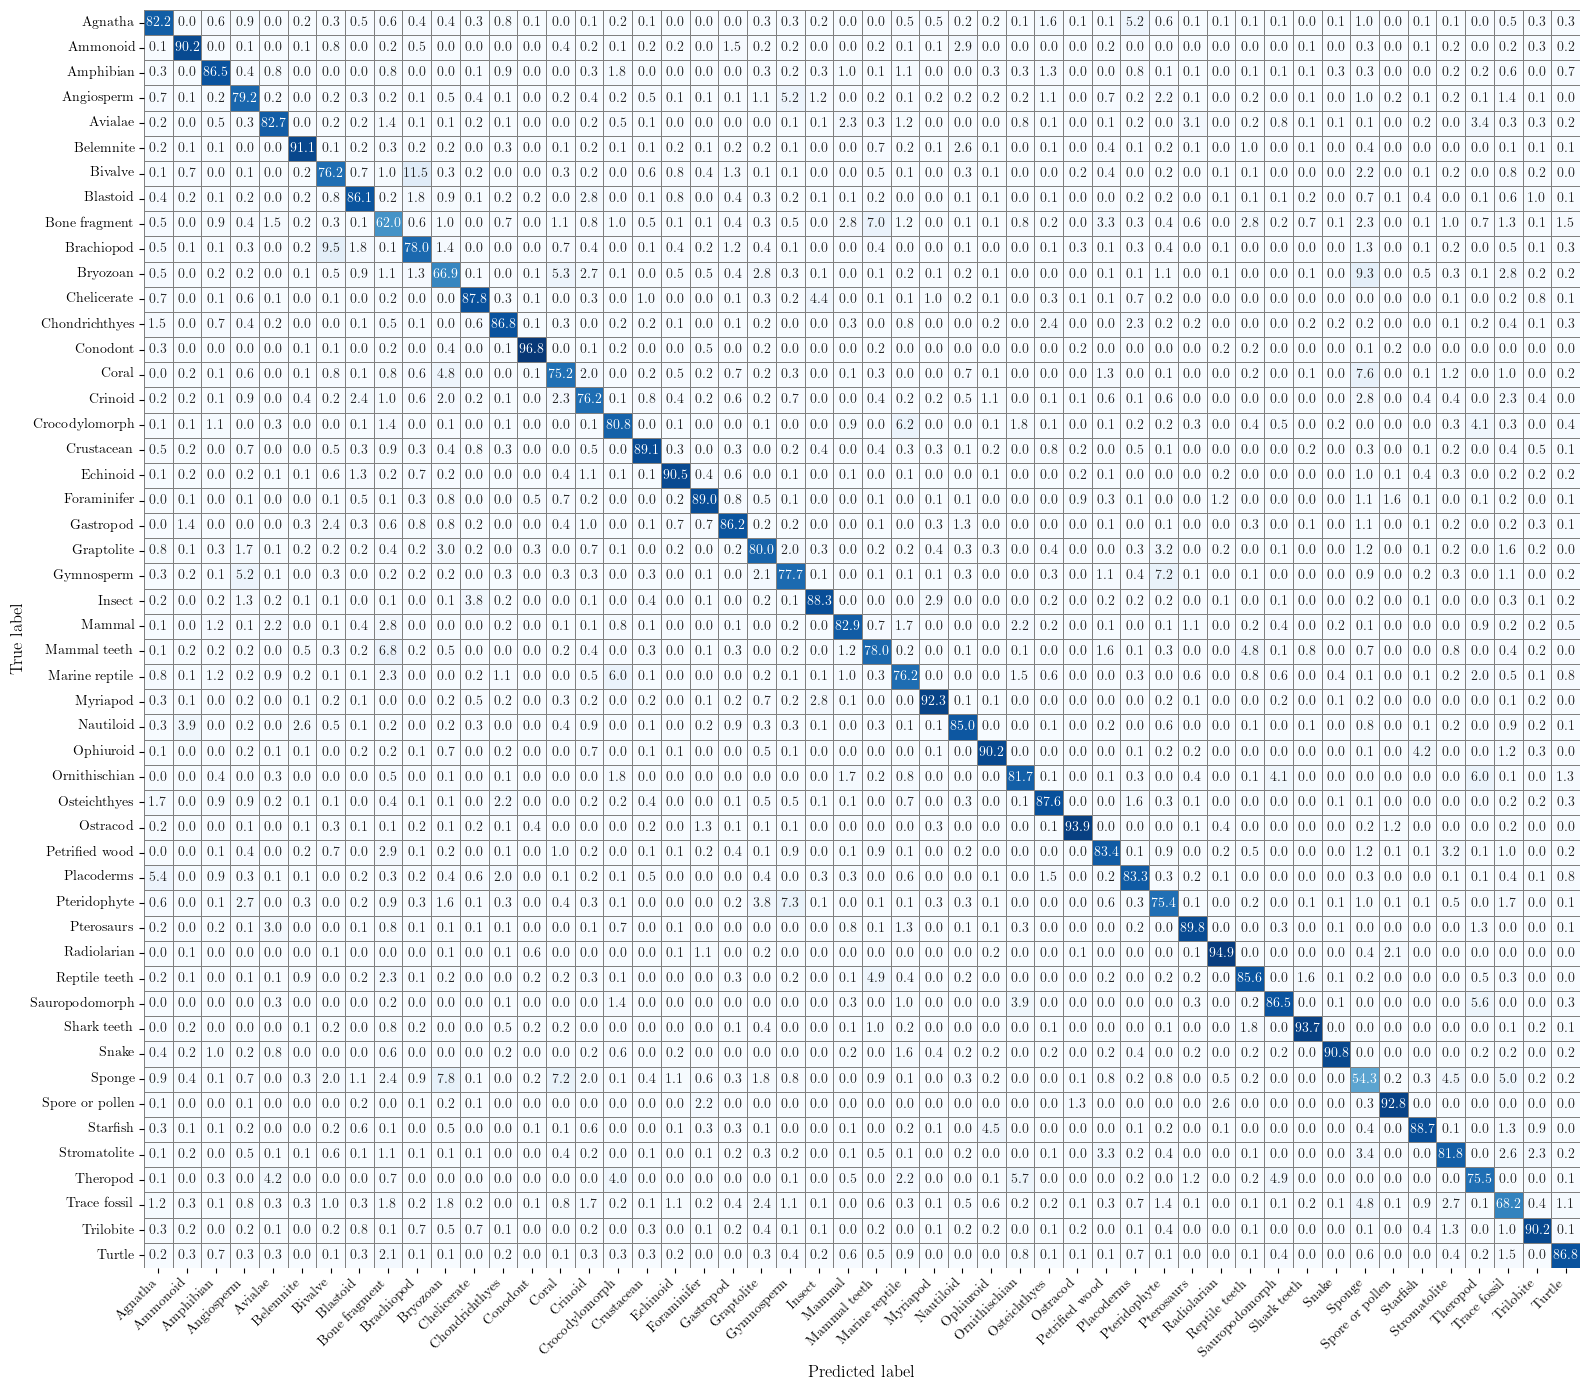

In [13]:







# ----------------------------
# Configuration
# ----------------------------
log_reg = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    class_weight="balanced"
)

# Stratified K-Fold to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions for all samples
cv_predictions = cross_val_predict(log_reg, features, true_labels, cv=skf)

# Compute normalized confusion matrix (per-class accuracy)
cm = confusion_matrix(true_labels, cv_predictions, normalize='true')

# Optional: convert to percentages for easier interpretation
cm_percent = cm * 100

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(16, 14))









sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".1f",             # Show one decimal
    cmap="Blues", 
    cbar=False,              # show colorbar
    xticklabels=class_names, 
    yticklabels=class_names,
    annot_kws={"fontsize":10, "fontweight":"bold"},
    linewidths=0.5, 
    linecolor='gray',
    vmin=0, vmax=100        # consistent color scale for percentages
)

# Labels and ticks
plt.xlabel("Predicted label", fontsize=12)
plt.ylabel("True label", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)



plt.tight_layout()

# Save figure as high-resolution PDF
plt.savefig(os.path.join(save_loc, "confusion_matrix.pdf"), dpi=500, bbox_inches='tight')

plt.show()
plt.close()


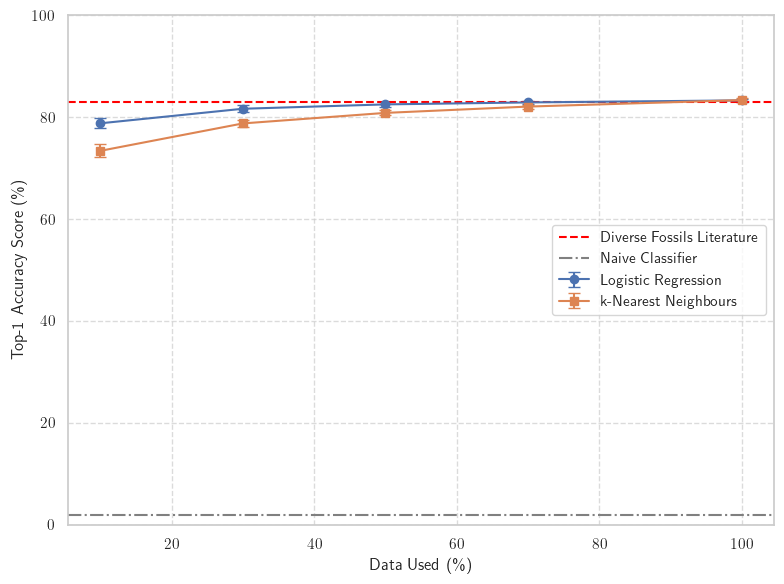

In [14]:



# ----------------------------
# Baseline accuracy
# ----------------------------
# Compute the accuracy of always predicting the most common class
most_common_class = Counter(true_labels).most_common(1)[0][0]
baseline_accuracy = np.mean(true_labels == most_common_class)

# ----------------------------
# Ensure numeric types for plotting
# ----------------------------
agg_df['mean_top1_accuracy'] = agg_df['mean_top1_accuracy'].astype(float)
agg_df['std_top1_accuracy'] = agg_df['std_top1_accuracy'].astype(float)
agg_df['train_fraction'] = agg_df['train_fraction'].astype(float)

# ----------------------------
# Plot settings
# ----------------------------
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

df_plot = agg_df.copy()
markers = ['o', 's', 'D', '^', 'v', 'p']

classifier_order = ["Logistic Regression", "k-Nearest Neighbours"]

# ----------------------------
# Plot classifiers with error bars
# ----------------------------
for i, clf_name in enumerate(classifier_order):
    group = df_plot[df_plot['classifier'] == clf_name]
    plt.errorbar(
        group['train_fraction']*100,             # Convert fraction to %
        group['mean_top1_accuracy']*100,         # Convert to %
        yerr=group['std_top1_accuracy']*100,     # Convert to %
        marker=markers[i % len(markers)],
        capsize=4,
        label=clf_name
    )

# ----------------------------
# Literature performance lines
# ----------------------------
# Main literature benchmark
plt.axhline(
    y=literature_best[dataset_name]*100,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label=f"{dataset_name} Literature"
)

# Specific benchmarks for Endless Forams
if dataset_name == "Endless Forams Original":
    plt.axhline(
        y=90.3,
        color='purple',
        linestyle='-.',
        linewidth=1.5,
        label="Custom CNN Forams Literature"
    )
    plt.axhline(
        y=92.0,
        color='green',
        linestyle=':',
        linewidth=1.5,
        label="Metric Learning Forams Literature"
    )

# ----------------------------
# Naive classifier line
# ----------------------------
plt.axhline(
    y=baseline_accuracy*100,
    color='gray',
    linestyle='-.',
    linewidth=1.5,
    label="Naive Classifier"
)

# ----------------------------
# Axis labels, limits, grid, legend
# ----------------------------
plt.xlabel("Data Used (\%)")
plt.ylabel("Top-1 Accuracy Score (\%)")
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed gridlines
plt.legend(loc='best')
plt.tight_layout()

# ----------------------------
# Save figure
# ----------------------------
plt.savefig(os.path.join(save_loc, "Accuracy_with_data.pdf"), dpi=500, bbox_inches='tight')
plt.show()
plt.close()


SUPERVISED FEW SHOT

The Below Code analyses the Few Shot Peformance


In [15]:
%%time

# ----------------------------
# Few-shot sampling function
# ----------------------------
def sample_few_shot_per_class_randomized(X, y, k_per_class):
    """
    Randomly sample k_per_class examples per class for training.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix.
    y : array-like, shape (n_samples,)
        True labels.
    k_per_class : int
        Number of samples to pick per class.

    Returns
    -------
    train_idx : np.ndarray
        Indices selected for the training set.
    test_idx : np.ndarray
        Remaining indices to use as the test set.
    
    Notes
    -----
    - Sampling is done without replacement.
    - Different calls return different samples (randomized).
    - Ensures each class is represented by up to k_per_class samples.

  

    - If a class has fewer than k_per_class samples, all samples are used.
    - Test set may be very small for classes with few examples.
    - Metrics are averaged over `n_repeats` randomized trials.

    """
    train_idx = []
    classes = np.unique(y)

    for cls in classes:
        cls_idx = np.where(y == cls)[0]
        n_samples = min(k_per_class, len(cls_idx) - 1)  # handle small classes
        sampled_idx = np.random.choice(cls_idx, size=n_samples, replace=False)
        train_idx.extend(sampled_idx)

    train_idx = np.array(train_idx)
    all_idx = np.arange(len(y))
    test_idx = np.setdiff1d(all_idx, train_idx)  # all other indices go to test

    return train_idx, test_idx

# ----------------------------
# Few-shot evaluation settings
# ----------------------------
Few_shot_values = [1, 2, 3, 5, 10, 20]  # number of training examples per class
n_repeats = 50  # number of repeated trials per few-shot setting
all_results = []  # list to store results

# ----------------------------
# Main evaluation loop
# ----------------------------
for k in tqdm(Few_shot_values, desc="Few-shot per class"):
    

    # ----------------------------
    # Classifiers definition
    # ----------------------------
    classifiers = {
        "k-Nearest Neighbours": Pipeline([
            ("normalize", Normalizer(norm='l2')),  # L2-normalize samples for cosine distance
            ("knn", KNeighborsClassifier(n_neighbors=min(5, k), metric='cosine'))  # k-NN limited by few-shot size
        ]),
        "Logistic Regression": LogisticRegression(
            random_state=42, max_iter=1000, class_weight="balanced"  # handle imbalanced classes
        ),
    }

    # ----------------------------
    # Evaluate each classifier
    # ----------------------------
    for clf_name, clf in tqdm(classifiers.items(), desc=f"Classifiers for k={k}", leave=False):
        

        # Initialize metrics storage for repeats
        repeat_metrics = {m: [] for m in [
            "top1", "top2", "top3", "f1_macro", "f1_weighted",
            "precision_macro", "recall_macro", "specificity_macro", "balanced_accuracy"
        ]}
        successful_repeats = 0

        for repeat in tqdm(range(n_repeats), desc=f"Repeats for {clf_name}, k={k}", leave=False):
            try:
                # Random few-shot sampling
                train_idx, test_idx = sample_few_shot_per_class_randomized(
                    features, true_labels, k_per_class=k
                )
            except ValueError as e:
                # Skip if sampling fails (e.g., not enough samples)
                print(f"Repeat {repeat+1}: {e}")
                continue

            X_train, y_train = features[train_idx], true_labels[train_idx]
            X_test, y_test = features[test_idx], true_labels[test_idx]

            # ----------------------------
            # Fit classifier
            # ----------------------------
            clf.fit(X_train, y_train)

            # ----------------------------
            # Make predictions
            # ----------------------------
            if hasattr(clf, "predict_proba"):
                y_probas = clf.predict_proba(X_test)
                y_pred = clf.classes_[np.argmax(y_probas, axis=1)]
                repeat_metrics["top1"].append(
                    calculate_top_k_accuracy(y_test, y_probas, k=1, classes=clf.classes_)
                )
                repeat_metrics["top2"].append(
                    calculate_top_k_accuracy(y_test, y_probas, k=2, classes=clf.classes_)
                )
                repeat_metrics["top3"].append(
                    calculate_top_k_accuracy(y_test, y_probas, k=3, classes=clf.classes_)
                )
            else:
                y_pred = clf.predict(X_test)
                repeat_metrics["top1"].append(accuracy_score(y_test, y_pred))
                repeat_metrics["top2"].append(np.nan)
                repeat_metrics["top3"].append(np.nan)

            # ----------------------------
            # Compute additional metrics
            # ----------------------------
            repeat_metrics["f1_macro"].append(f1_score(y_test, y_pred, average='macro', zero_division=0))
            repeat_metrics["f1_weighted"].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
            repeat_metrics["precision_macro"].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            repeat_metrics["recall_macro"].append(recall_score(y_test, y_pred, average='macro', zero_division=0))

            # Confusion matrix for specificity
            cm = confusion_matrix(y_test, y_pred)
            tn = np.sum(cm) - (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))
            fp = np.sum(cm, axis=0) - np.diag(cm)
            denom = tn + fp
            specificity_per_class = np.where(denom > 0, tn / denom, np.nan)
            repeat_metrics["specificity_macro"].append(np.nanmean(specificity_per_class))

            # Balanced accuracy
            repeat_metrics["balanced_accuracy"].append(balanced_accuracy_score(y_test, y_pred))
            successful_repeats += 1

        # ----------------------------
        # Aggregate results for this classifier and k
        # ----------------------------
        all_results.append({
            "few_shot_values": k,
            "classifier": clf_name,
            "n_repeats_successful": successful_repeats,
            "mean_top1_accuracy": np.nanmean(repeat_metrics["top1"]),
            "std_top1_accuracy": np.nanstd(repeat_metrics["top1"]),
            "mean_top2_accuracy": np.nanmean(repeat_metrics["top2"]),
            "std_top2_accuracy": np.nanstd(repeat_metrics["top2"]),
            "mean_top3_accuracy": np.nanmean(repeat_metrics["top3"]),
            "std_top3_accuracy": np.nanstd(repeat_metrics["top3"]),
            "f1_macro": np.nanmean(repeat_metrics["f1_macro"]),
            "f1_macro_std": np.nanstd(repeat_metrics["f1_macro"]),
            "f1_weighted": np.nanmean(repeat_metrics["f1_weighted"]),
            "f1_weighted_std": np.nanstd(repeat_metrics["f1_weighted"]),
            "precision_macro": np.nanmean(repeat_metrics["precision_macro"]),
            "precision_macro_std": np.nanstd(repeat_metrics["precision_macro"]),
            "recall_macro": np.nanmean(repeat_metrics["recall_macro"]),
            "recall_macro_std": np.nanstd(repeat_metrics["recall_macro"]),
            "specificity_macro": np.nanmean(repeat_metrics["specificity_macro"]),
            "specificity_macro_std": np.nanstd(repeat_metrics["specificity_macro"]),
            "balanced_accuracy": np.nanmean(repeat_metrics["balanced_accuracy"]),
            "balanced_accuracy_std": np.nanstd(repeat_metrics["balanced_accuracy"])
        })

# ----------------------------
# Convert results to DataFrame
# ----------------------------
few_shot_results_df = pd.DataFrame(all_results)

# Optionally format for LaTeX table
formatted_results = []
for row in all_results:
    formatted_results.append({
        "Few-Shot k": row["few_shot_values"],
        "Classifier": row["classifier"],
        "Repeats Successful": row.get("n_repeats_successful", 1),
        "Top-1 Accuracy": f"{row['mean_top1_accuracy']:.4f} ± {row['std_top1_accuracy']:.4f}",
        "Top-2 Accuracy": f"{row['mean_top2_accuracy']:.4f} ± {row['std_top2_accuracy']:.4f}" if not np.isnan(row['mean_top2_accuracy']) else "N/A",
        "Top-3 Accuracy": f"{row['mean_top3_accuracy']:.4f} ± {row['std_top3_accuracy']:.4f}" if not np.isnan(row['mean_top3_accuracy']) else "N/A",
        "F1 Macro": f"{row['f1_macro']:.4f} ± {row['f1_macro_std']:.4f}",
        "F1 Weighted": f"{row['f1_weighted']:.4f} ± {row['f1_weighted_std']:.4f}",
        "Precision Macro": f"{row['precision_macro']:.4f} ± {row['precision_macro_std']:.4f}",
        "Recall Macro": f"{row['recall_macro']:.4f} ± {row['recall_macro_std']:.4f}",
        "Specificity Macro": f"{row['specificity_macro']:.4f} ± {row['specificity_macro_std']:.4f}",
        "Balanced Accuracy": f"{row['balanced_accuracy']:.4f} ± {row['balanced_accuracy_std']:.4f}"
    })

latex_formatted = pd.DataFrame(formatted_results)



# Display nicely in notebook
display_scrollable_df(few_shot_results_df)





# Save CSV
results_csv_path = os.path.join(save_loc, "few_shot_cv_results.csv")
few_shot_results_df.to_csv(results_csv_path, index=False)
print(f"\nSaved few_shot results to {results_csv_path}")

# Shorten numbers for display, e.g., 0.912345 -> 0.9123 ± 0.0123
def shorten_num(s):
    # If the string is already 'N/A', leave it
    if "N/A" in s:
        return s
    # Otherwise, shorten the float strings in "mean ± std"
    try:
        mean, std = s.split("±")
        mean = f"{float(mean.strip()):.3f}"
        std = f"{float(std.strip()):.3f}"
        return f"{mean} ± {std}"
    except:
        return s

# Extract the mean from a "mean ± std" string for comparison
def extract_mean(s):
    if "N/A" in s:
        return np.nan
    try:
        mean, std = s.split("±")
        return float(mean.strip())
    except:
        return np.nan








# Prepare numeric columns for bolding max values in LaTeX
numeric_cols = [
    "Top-1 Accuracy", "Top-2 Accuracy", "Top-3 Accuracy",
    "F1 Macro", "F1 Weighted", "Precision Macro", "Recall Macro",
    "Specificity Macro", "Balanced Accuracy"
]

if n_classes <= 2:
    numeric_cols = [c for c in numeric_cols if c not in ["Top-2 Accuracy", "Top-3 Accuracy"]]





bolded_df = latex_formatted.copy()
for col in numeric_cols:
    # Shorten all numbers
    bolded_df[col] = bolded_df[col].apply(shorten_num)
    # Extract means for comparison — use latex_formatted raw data (safe)
    means = latex_formatted[col].apply(extract_mean)
    valid_means = means.replace([-np.inf, np.inf], np.nan).dropna()
    if valid_means.empty:
        continue
    max_idx = valid_means.idxmax()
    if "N/A" not in str(bolded_df.at[max_idx, col]):
        bolded_df.at[max_idx, col] = r"\textbf{" + bolded_df.at[max_idx, col] + "}"

# Export LaTeX
latex_file_path = os.path.join(save_loc, "few_shot_results.tex")

# Generate table body from pandas
table_body = bolded_df.to_latex(index=False, escape=False)

# Extract only the rows (strip the default tabular environment from pandas)
table_lines = table_body.splitlines()
core_table = "\n".join(table_lines[2:-1])

# Count columns for tabularx column spec
n_cols = bolded_df.shape[1]
col_spec = "l" + "X" * (n_cols - 1)

latex_content = rf"""
\begin{{table}}[ht]
\centering
\tiny  % <-- make table font smaller
\caption{{Few Shot Classification Results}}
\label{{tab:few_shotclassification_results}}
\begin{{tabularx}}{{\textwidth}}{{{col_spec}}}
\toprule
{core_table}
\bottomrule
\end{{tabularx}}
\end{{table}}
"""

with open(latex_file_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"LaTeX table saved to {latex_file_path}")









Few-shot per class:   0%|          | 0/6 [00:00<?, ?it/s]

Classifiers for k=1:   0%|          | 0/2 [00:00<?, ?it/s]

Repeats for k-Nearest Neighbours, k=1:   0%|          | 0/50 [00:00<?, ?it/s]

Repeats for Logistic Regression, k=1:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers for k=2:   0%|          | 0/2 [00:00<?, ?it/s]

Repeats for k-Nearest Neighbours, k=2:   0%|          | 0/50 [00:00<?, ?it/s]

Repeats for Logistic Regression, k=2:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers for k=3:   0%|          | 0/2 [00:00<?, ?it/s]

Repeats for k-Nearest Neighbours, k=3:   0%|          | 0/50 [00:00<?, ?it/s]

Repeats for Logistic Regression, k=3:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers for k=5:   0%|          | 0/2 [00:00<?, ?it/s]

Repeats for k-Nearest Neighbours, k=5:   0%|          | 0/50 [00:00<?, ?it/s]

Repeats for Logistic Regression, k=5:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers for k=10:   0%|          | 0/2 [00:00<?, ?it/s]

Repeats for k-Nearest Neighbours, k=10:   0%|          | 0/50 [00:00<?, ?it/s]

Repeats for Logistic Regression, k=10:   0%|          | 0/50 [00:00<?, ?it/s]

Classifiers for k=20:   0%|          | 0/2 [00:00<?, ?it/s]

Repeats for k-Nearest Neighbours, k=20:   0%|          | 0/50 [00:00<?, ?it/s]

Repeats for Logistic Regression, k=20:   0%|          | 0/50 [00:00<?, ?it/s]


Saved few_shot results to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/few_shot_cv_results.csv
LaTeX table saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/few_shot_results.tex
CPU times: user 5min 28s, sys: 21.8 s, total: 5min 50s
Wall time: 5min 50s


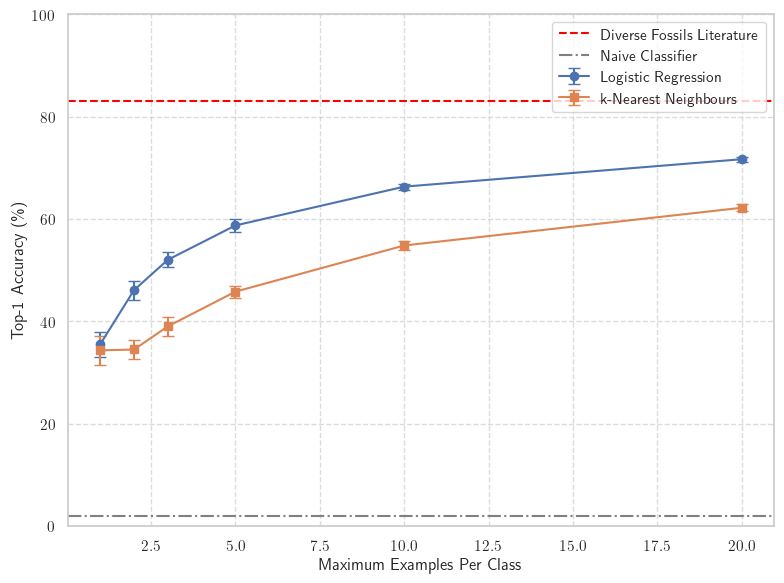

In [16]:

# Convert data types to ensure correct plotting
few_shot_results_df['mean_top1_accuracy'] = few_shot_results_df['mean_top1_accuracy'].astype(float)
few_shot_results_df['std_top1_accuracy'] = few_shot_results_df['std_top1_accuracy'].astype(float)
few_shot_results_df['few_shot_values'] = few_shot_results_df['few_shot_values'].astype(float)

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

df_plot = few_shot_results_df.copy()

for i, clf_name in enumerate(classifier_order):
    group = df_plot[df_plot['classifier'] == clf_name]
    plt.errorbar(
        group['few_shot_values'],                # x-axis: max examples per class
        group['mean_top1_accuracy']*100,         # convert to %
        yerr=group['std_top1_accuracy']*100,     # standard deviation over repeats
        marker=markers[i % len(markers)],
        capsize=4,
        label=clf_name
    )


# Horizontal dashed line for literature best results
plt.axhline(
    y=literature_best[dataset_name]*100,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label=f"{dataset_name} Literature"
)

# Dataset-specific references
if dataset_name == "Endless Forams Original":
    plt.axhline(y=90.3, color='purple', linestyle='-.', linewidth=1.5,
                label="Custom CNN Forams Literature")
    plt.axhline(y=92.0, color='green', linestyle=':', linewidth=1.5,
                label="Metric Learning Forams Literature")

# Dashed line for naive classifier (majority class)
plt.axhline(y=baseline_accuracy*100, color='gray', linestyle='-.', linewidth=1.5,
            label="Naive Classifier")

# Axes, labels, and grid
plt.xlabel("Maximum Examples Per Class")
plt.ylabel("Top-1 Accuracy (\%)")
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)  # subtle dashed gridlines
plt.legend(loc='best')
plt.tight_layout()

# Save figure 
plt.savefig(os.path.join(save_loc, "Few_shot_accuracy.pdf"), dpi=500)
plt.show()



UNSUPERVISED


In the below cells we do the Unsupervised Analysis. FIX THE UMAP TO USE A LOWER NUMBER OF DIMENSIONS THAN THE NUMBER OF NEIGHBOURS, results still work in progress until this is fixed. Rerun data with more justified clusering dimension choice but doesn't change results much so fine for talk. 









In [17]:
%%time





def calculate_purity(y_true, y_pred):
    """
    Compute clustering purity (noise points -1 are included in denominator).

    Returns the proportion of samples that belong to the majority true class 
    within each cluster.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    total = len(y_true)
    purity_sum = 0

    # Only consider clusters that are not noise
    for c in np.unique(y_pred[y_pred != -1]):
        mask = (y_pred == c)
        maj = mode(y_true[mask], keepdims=True)
        purity_sum += int(maj.count[0])

    return purity_sum / total

def save_image_grid(image_paths, save_path, n_cols=5, thumb_size=(128, 128)):
    """
    Save a grid of thumbnails given a list of image paths.

    Parameters
    ----------
    image_paths : list of str
        File paths to images to include in grid.
    save_path : str
        Output path for saved grid image.
    n_cols : int
        Number of images per row.
    thumb_size : tuple
        Size of each thumbnail (width, height).
    """
    images = [Image.open(p).convert("RGB").resize(thumb_size) for p in image_paths]
    n_rows = int(np.ceil(len(images) / n_cols))
    grid = Image.new("RGB", (n_cols * thumb_size[0], n_rows * thumb_size[1]), (255, 255, 255))
    for idx, img in enumerate(images):
        r, c = divmod(idx, n_cols)
        grid.paste(img, (c * thumb_size[0], r * thumb_size[1]))
    grid.save(save_path)


def cluster_pipeline(features, true_labels, image_paths=None, save_dir="clustering_results", random_state=42, top_k_outliers=10):
    """
    Run PCA-based 'benchmark' and UMAP-based 'exploratory' clustering pipelines
    using K-Means, Bayesian GMM, and HDBSCAN. Evaluates internal and external metrics, 
    logs results, and optionally saves exemplar/outlier images.

    Parameters
    ----------
    features : ndarray (n_samples, n_features)
        Input feature vectors.
    true_labels : array-like
        Ground-truth labels for external evaluation metrics.
    image_paths : list of str, optional
        Paths to original images (for saving outliers/medoids).
    save_dir : str
        Directory where results (metrics, images) are stored.
    random_state : int
        Reproducibility seed.
    top_k_outliers : int
        Number of top outliers to save (HDBSCAN only).
    
    Returns
    -------
    df : pd.DataFrame
        DataFrame with clustering metrics.
    labels_dict : dict
        Dictionary of pipeline/algorithm → cluster assignments.
    """
    os.makedirs(save_dir, exist_ok=True)
    X = np.asarray(features)
    y = np.asarray(true_labels)
    n_classes = len(np.unique(y))
    tqdm.write(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features, {n_classes} classes")


    results = []
    labels_dict = {}

    # --- Dimensionality reduction ---
    # PCA components for 95% variance
    pca_95 = PCA(n_components=0.95, random_state=random_state)
    pca_95.fit(X)
    n_components_95 = pca_95.n_components_

    # Cap components to avoid overfitting
    max_components = min(50, X.shape[1])
    n_final_pca = min(n_components_95, max_components)
    n_comp_UMAP = 15  # exploratory embedding size

    tqdm.write(f"PCA components for 95% variance: {n_components_95}")
    tqdm.write(f"Final PCA components used: {n_final_pca}")

    pipeline_component_counts = {
        "PCA": n_final_pca,
        "Exploratory UMAP": n_comp_UMAP
    }

    # Prepare embeddings
    pipelines = {
        "PCA": PCA(n_components=n_final_pca, random_state=random_state).fit_transform(X),
        "Exploratory UMAP": umap.UMAP(
            n_components=n_comp_UMAP, n_neighbors=30, min_dist=0.0, 
            random_state=random_state, metric='cosine'
        ).fit_transform(X)
    }

    # --- Main loop over pipelines (outer tqdm) ---
    for pipe_name, X_proc in tqdm(pipelines.items(), desc="Pipelines"):
        
        def safe_internal(pred):
            """
            Compute internal metrics safely, ignoring noise points.
            Returns NaN if clustering is degenerate.
            """
            valid = len(np.unique(pred[pred != -1])) > 1 and np.sum(pred != -1) > 1
            if not valid:
                return np.nan, np.nan
            try:
                sil = silhouette_score(X_proc[pred != -1], pred[pred != -1])
            except:
                sil = np.nan
            try:
                db = davies_bouldin_score(X_proc[pred != -1], pred[pred != -1])
            except:
                db = np.nan
            return sil, db

        # --- KMeans (Known K) ---
        km = KMeans(n_clusters=n_classes, n_init=10, random_state=random_state).fit(X_proc)
        km_labels = km.labels_
        sil, db = safe_internal(km_labels)
        results.append({
            "Pipeline": pipe_name, "Algorithm": "KMeans (Known K)",
            "n_clusters": len(np.unique(km_labels)),
            "ARI": adjusted_rand_score(y, km_labels),
            "AMI": adjusted_mutual_info_score(y, km_labels),
            "Purity": calculate_purity(y, km_labels),
            "Silhouette": sil, "DaviesBouldin": db,
            "Noise Fraction": np.mean(km_labels == -1),
            "Components Used": pipeline_component_counts.get(pipe_name, np.nan)
        })
        labels_dict[(pipe_name, "KMeans (Known K)")] = km_labels
        tqdm.write("✔ KMeans (Known K) fitted")

        # --- KMeans (Unknown K, Auto) ---
        best_sil, best_k = -1, -1
        k_range = range(2, min(2 * n_classes, 50))  # cap at 50 clusters
        for k in tqdm(k_range, desc=f"KMeans Auto-K ({pipe_name})", leave=False):
            if X_proc.shape[0] <= k:  # cannot exceed samples
                break
            km_search = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(X_proc)
            sil_score = silhouette_score(X_proc, km_search.labels_)
            if sil_score > best_sil:
                best_sil, best_k = sil_score, k
        
        if best_k != -1:  # best K found
            km_auto = KMeans(n_clusters=best_k, n_init=10, random_state=random_state).fit(X_proc)
            km_auto_labels = km_auto.labels_
            sil, db = safe_internal(km_auto_labels)
            results.append({
                "Pipeline": pipe_name, "Algorithm": "KMeans (Unknown K)",
                "n_clusters": len(np.unique(km_auto_labels)),
                "ARI": adjusted_rand_score(y, km_auto_labels),
                "AMI": adjusted_mutual_info_score(y, km_auto_labels),
                "Purity": calculate_purity(y, km_auto_labels),
                "Silhouette": sil, "DaviesBouldin": db,
                "Noise Fraction": np.mean(km_auto_labels == -1),
                "Components Used": pipeline_component_counts.get(pipe_name, np.nan)
            })
            labels_dict[(pipe_name, "KMeans (Unknown K)")] = km_auto_labels
            tqdm.write(f"✔ KMeans Auto-K fitted (best_k={best_k})")

        # --- Bayesian GMM ---
        bgmm = BayesianGaussianMixture(
            n_components=min(2 * n_classes, 50),  # upper bound, unused pruned
            weight_concentration_prior=0.1,
            random_state=random_state
        ).fit(X_proc)
        bgmm_labels = bgmm.predict(X_proc)
        sil, db = safe_internal(bgmm_labels)
        results.append({
            "Pipeline": pipe_name, "Algorithm": "Bayesian GMM",
            "n_clusters": len(np.unique(bgmm_labels)),
            "ARI": adjusted_rand_score(y, bgmm_labels),
            "AMI": adjusted_mutual_info_score(y, bgmm_labels),
            "Purity": calculate_purity(y, bgmm_labels),
            "Silhouette": sil, "DaviesBouldin": db,
            "Noise Fraction": np.mean(bgmm_labels == -1),
            "Components Used": pipeline_component_counts.get(pipe_name, np.nan)
        })
        labels_dict[(pipe_name, "Bayesian GMM")] = bgmm_labels
        tqdm.write("✔ Bayesian GMM fitted")

        # --- HDBSCAN ---
        hdb = hdbscan.HDBSCAN(
            min_cluster_size=max(5, int(0.02 * len(y))),  # heuristic
            metric='euclidean'
        ).fit(X_proc)
        hdb_labels = hdb.labels_
        sil, db = safe_internal(hdb_labels)
        results.append({
            "Pipeline": pipe_name, "Algorithm": "HDBSCAN",
            "n_clusters": len(np.unique(hdb_labels[hdb_labels != -1])),
            "ARI": adjusted_rand_score(y, hdb_labels),
            "AMI": adjusted_mutual_info_score(y, hdb_labels),
            "Purity": calculate_purity(y, hdb_labels),
            "Silhouette": sil, "DaviesBouldin": db,
            "Noise Fraction": np.mean(hdb_labels == -1),
            "Components Used": pipeline_component_counts.get(pipe_name, np.nan)
        })
        labels_dict[(pipe_name, "HDBSCAN")] = hdb_labels
        tqdm.write("✔ HDBSCAN fitted")

        # --- Outlier & Medoid saving (only Exploratory UMAP) ---
        if image_paths is not None and hasattr(hdb, "outlier_scores_") and pipe_name == "Exploratory UMAP":
            outlier_idx = np.argsort(hdb.outlier_scores_)[::-1][:top_k_outliers]
            save_image_grid([image_paths[i] for i in outlier_idx],
                            os.path.join(save_dir, f"{pipe_name}_HDBSCAN_top{top_k_outliers}_outliers.png"))
        
            for c in np.unique(hdb_labels[hdb_labels != -1]):
                mask = (hdb_labels == c)
                cluster_points = X_proc[mask]
                centroid = np.mean(cluster_points, axis=0)
                dists = np.linalg.norm(cluster_points - centroid, axis=1)
                medoid_idx = np.where(mask)[0][np.argmin(dists)]
                save_image_grid([image_paths[medoid_idx]],
                                os.path.join(save_dir, f"{pipe_name}_HDBSCAN_cluster{c}_medoid.png"),
                                n_cols=1)

    # --- Save results ---
    df = pd.DataFrame(results)
    df.to_csv(os.path.join(save_dir, "clustering_metrics.csv"), index=False)
    tqdm.write(f"✅ Saved metrics & images to {save_dir}")
    tqdm.write("\n--- Clustering Results ---")
    tqdm.write(df.to_string(index=False, float_format="%.4f"))
    tqdm.write("--------------------------\n")

    return df, labels_dict




    
   



df_metrics, labels_dict = cluster_pipeline(norm_features, true_labels, image_paths=file_paths, save_dir=save_loc)





def df_to_latex_best_resized(df, caption="Clustering results", label="tab:clustering_results", save_path=None):
    """
    Convert clustering metrics DataFrame into a LaTeX tabularx table.

    Highlights the best score per metric in bold. 
    - For ARI, AMI, Purity, Silhouette → higher is better.
    - For Davies-Bouldin (DBI) → lower is better.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with clustering results (must contain metrics columns).
    caption : str
        Table caption for LaTeX.
    label : str
        LaTeX label for referencing the table.
    save_path : str, optional
        Path to save the .tex file. If None, only returns LaTeX string.

    Returns
    -------
    latex_content : str
        Formatted LaTeX code for the table.
    """
    df_copy = df.copy()
    metrics = ["ARI", "AMI", "Purity", "Silhouette", "DaviesBouldin"]

    # Determine best values per metric
    best_vals = {}
    for col in metrics:
        col_data = df_copy[col].replace([np.inf, -np.inf], np.nan).dropna()
        if col_data.empty:
            continue
        if col == "DaviesBouldin":  # lower is better
            best_vals[col] = col_data.min()
        else:  # higher is better
            best_vals[col] = col_data.max()

    # Apply bold formatting with tolerance
    for col in metrics:
        if col in best_vals:
            df_copy[col] = df_copy[col].apply(
                lambda x: f"\\textbf{{{x:.4f}}}" if np.isclose(x, best_vals[col], rtol=1e-5, atol=1e-8) else f"{x:.4f}"
            )
        else:
            df_copy[col] = df_copy[col].apply(lambda x: f"{x:.4f}")

    # Clean up column names
    df_copy.rename(columns={
        'DaviesBouldin': 'DBI',
        'n_clusters': 'No. of Clusters'
    }, inplace=True)

    # Convert to LaTeX
    table_body = df_copy.to_latex(index=False, escape=False)
    table_lines = table_body.splitlines()
    core_table = "\n".join(table_lines[2:-1])  # strip header/footer

    # Column spec for tabularx
    n_cols = df_copy.shape[1]
    col_spec = "l" + "X" * (n_cols - 1)

    latex_content = rf"""
\begin{{table}}[ht]
\centering
\tiny
\caption{{{caption}}}
\label{{{label}}}
\begin{{tabularx}}{{\textwidth}}{{{col_spec}}}
\toprule
{core_table}
\bottomrule
\end{{tabularx}}
\end{{table}}
"""

    if save_path:
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(latex_content)
        print(f"✅ LaTeX table saved to {save_path}")

    return latex_content



latex_table = df_to_latex_best_resized(df_metrics, save_path = os.path.join(save_loc,"clustering_metrics.tex"))



Dataset: 59244 samples, 1024 features, 50 classes
PCA components for 95% variance: 535
Final PCA components used: 50


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Pipelines:   0%|          | 0/2 [00:00<?, ?it/s]

✔ KMeans (Known K) fitted


KMeans Auto-K (PCA):   0%|          | 0/48 [00:00<?, ?it/s]

✔ KMeans Auto-K fitted (best_k=39)


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


✔ Bayesian GMM fitted


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✔ HDBSCAN fitted
✔ KMeans (Known K) fitted


KMeans Auto-K (Exploratory UMAP):   0%|          | 0/48 [00:00<?, ?it/s]

✔ KMeans Auto-K fitted (best_k=37)


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


✔ Bayesian GMM fitted


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✔ HDBSCAN fitted
✅ Saved metrics & images to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m

--- Clustering Results ---
        Pipeline          Algorithm  n_clusters    ARI    AMI  Purity  Silhouette  DaviesBouldin  Noise Fraction  Components Used
             PCA   KMeans (Known K)          50 0.3148 0.5708  0.4789      0.1649         2.0605          0.0000               50
             PCA KMeans (Unknown K)          39 0.2777 0.5543  0.4198      0.1693         1.9669          0.0000               50
             PCA       Bayesian GMM          50 0.3092 0.5910  0.4713      0.1262         2.2057          0.0000               50
             PCA            HDBSCAN           0 0.0000 0.0000  0.0000         NaN            NaN          1.0000               50
Exploratory UMAP   KMeans (Known K)          50 0.3571 0.6390  0.5051      0.5636         0.5652  

This below cell computes a UMAP to visualise the clusters which are output by the clustering method. 


Computing global UMAP embedding (n_neighbors=30, min_dist=0.1)...


/opt/miniconda3/envs/ML2/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Saved: /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/UMAP_KMeans_known_k.pdf


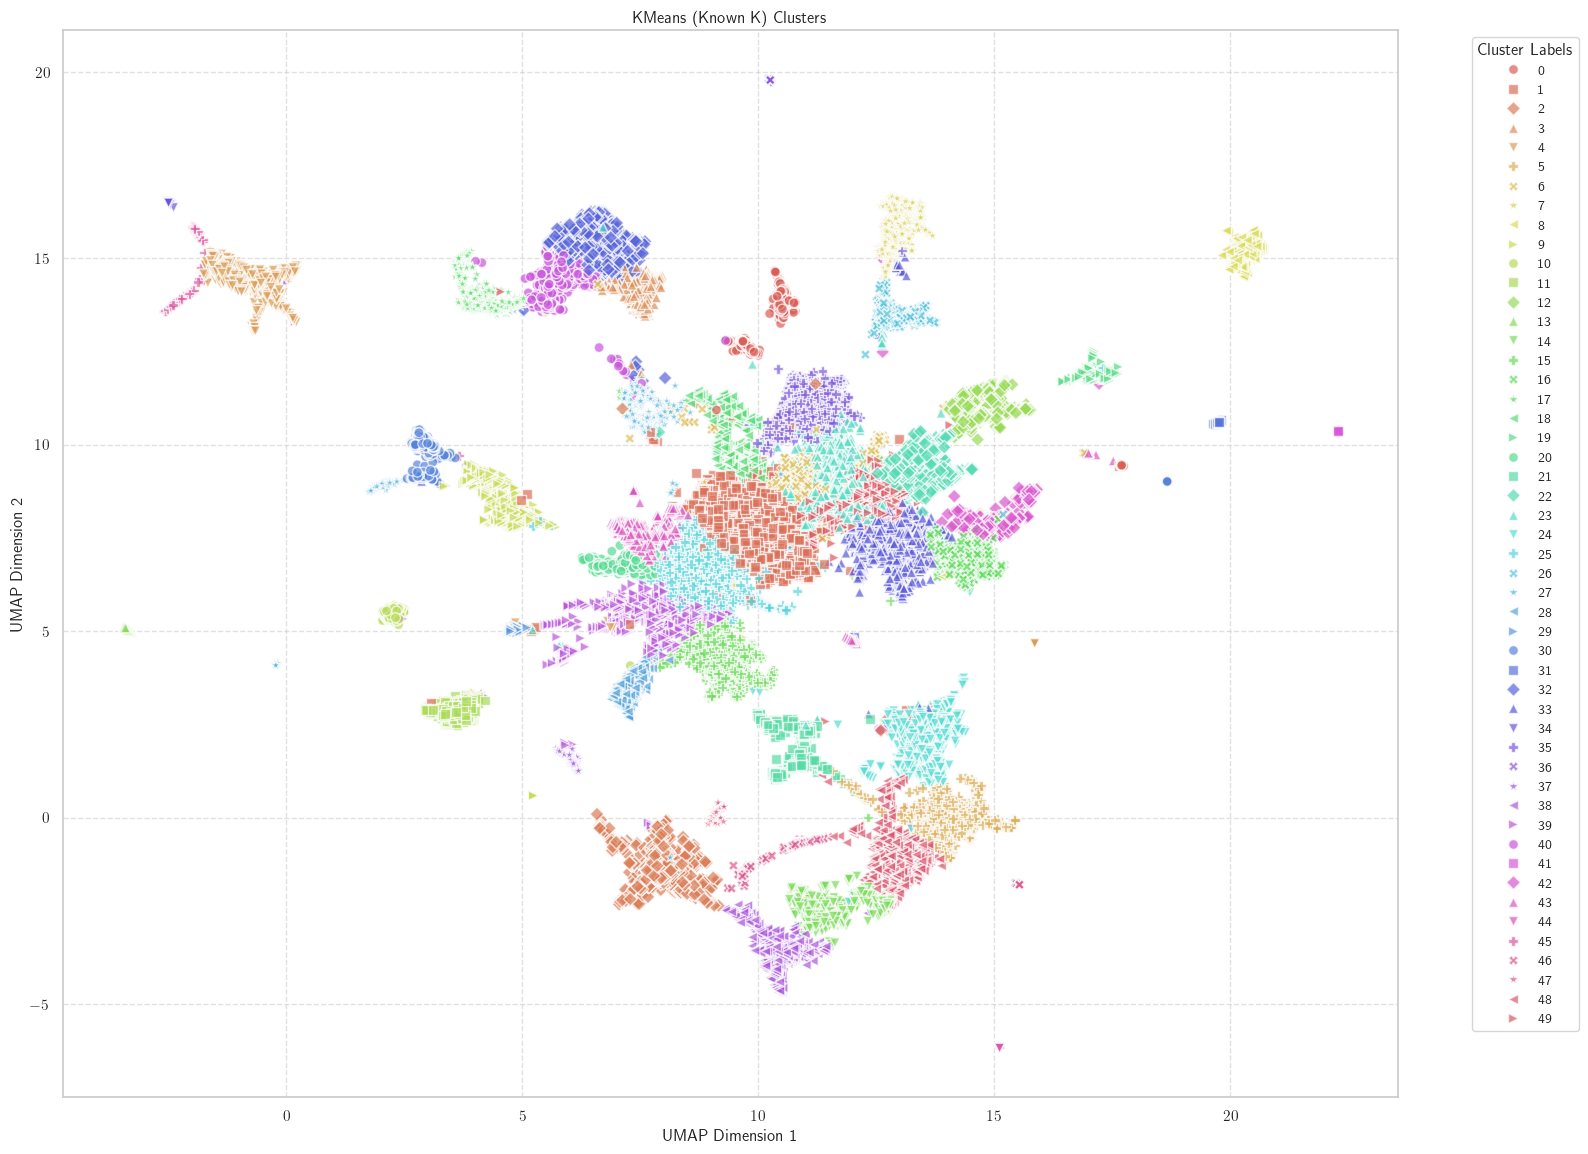

✅ Saved: /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/UMAP_KMeans_unknown_k.pdf


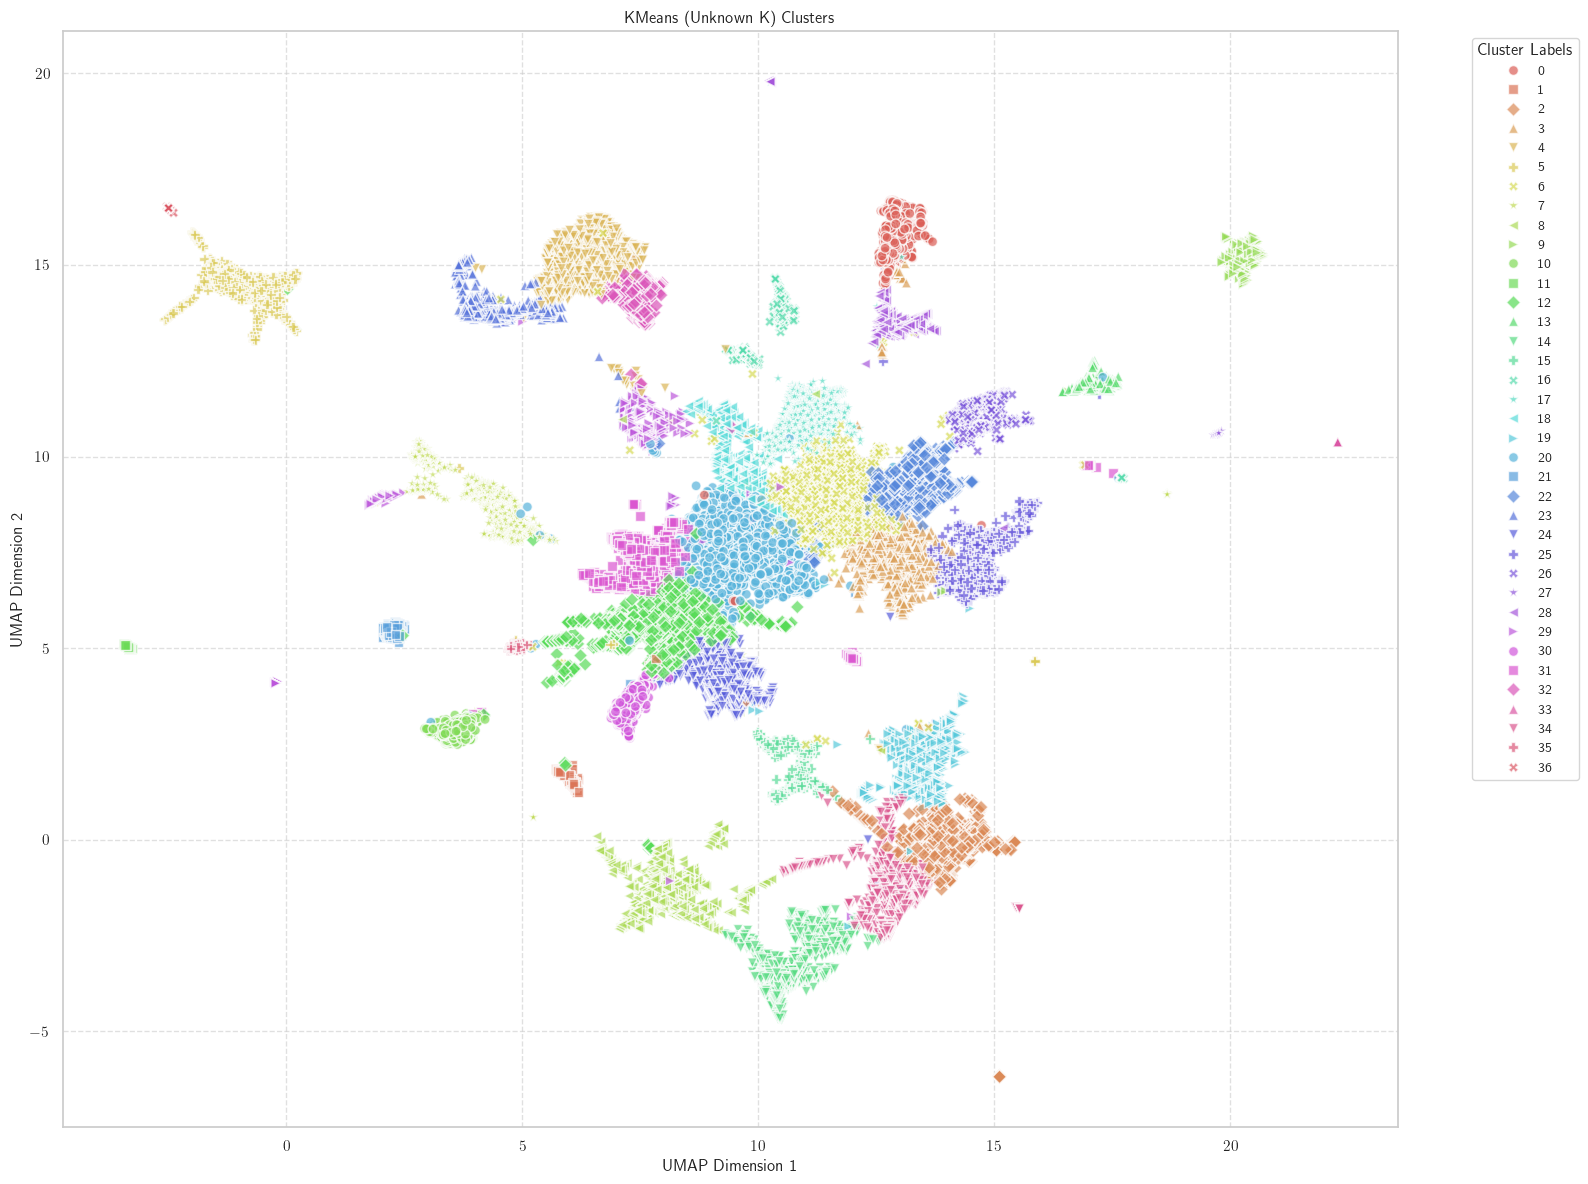

✅ Saved: /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/UMAP_BGMM.pdf


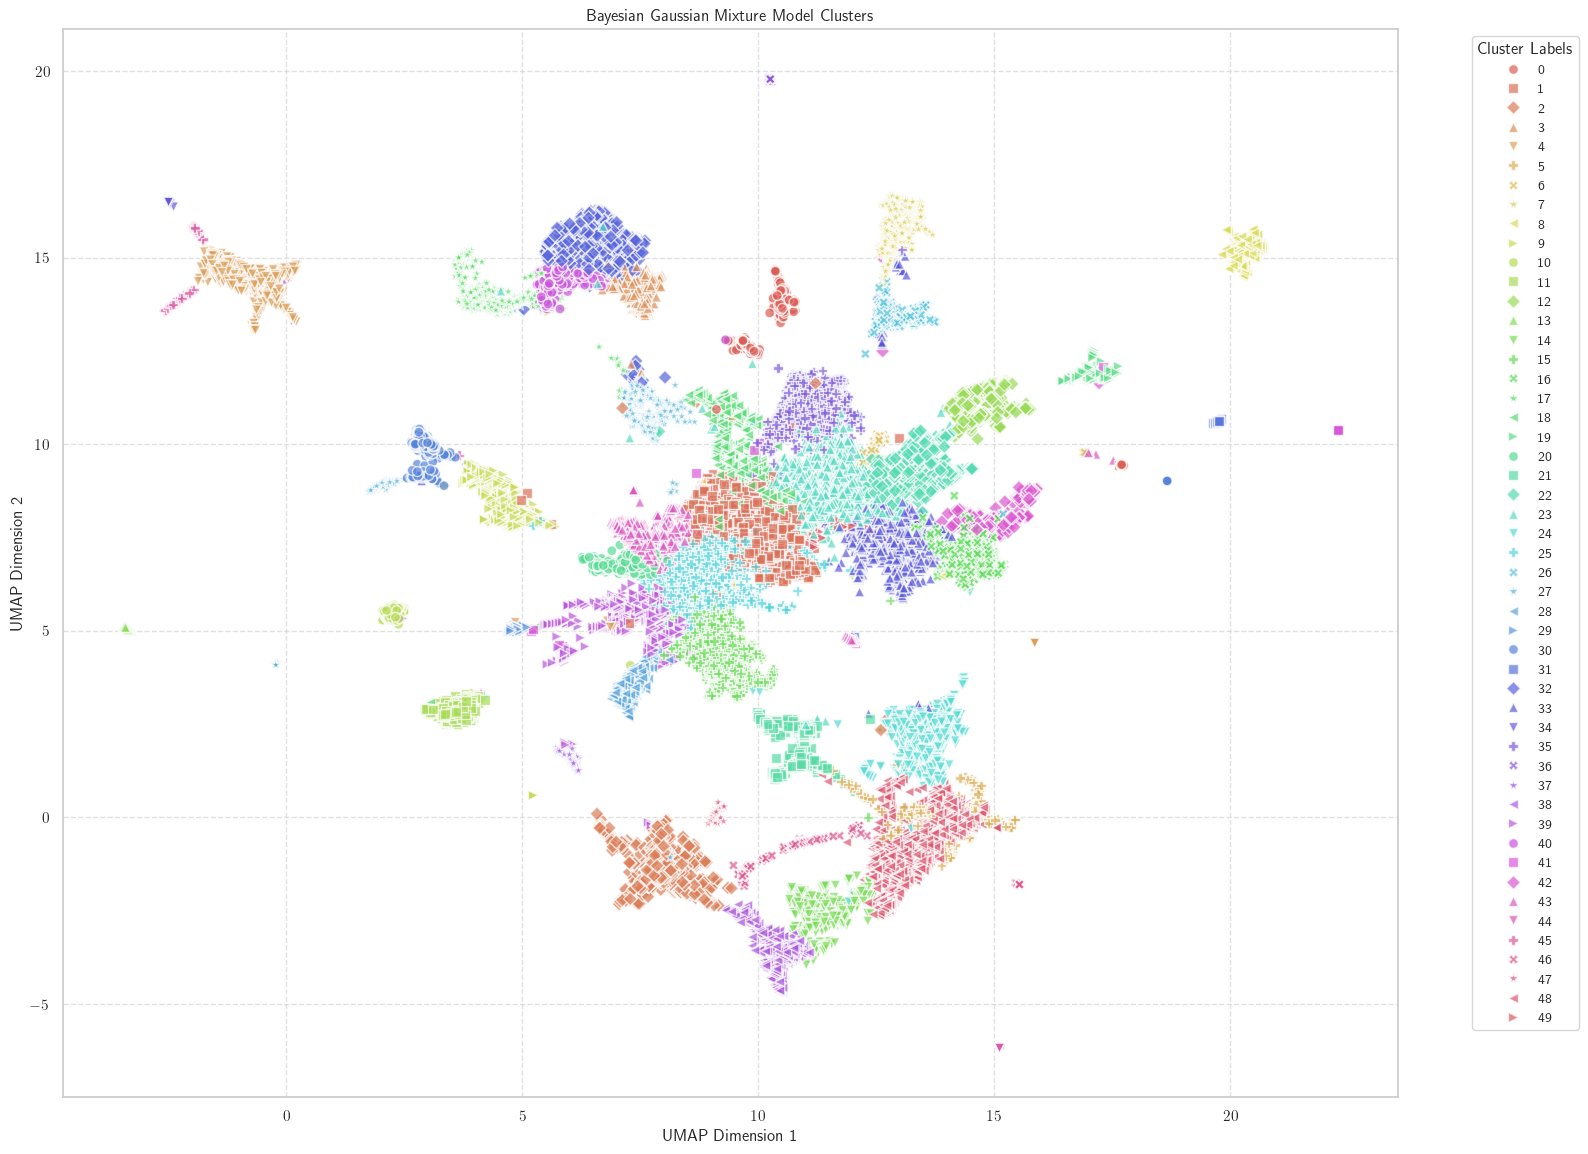

✅ Saved: /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/UMAP_HDBSCAN.pdf


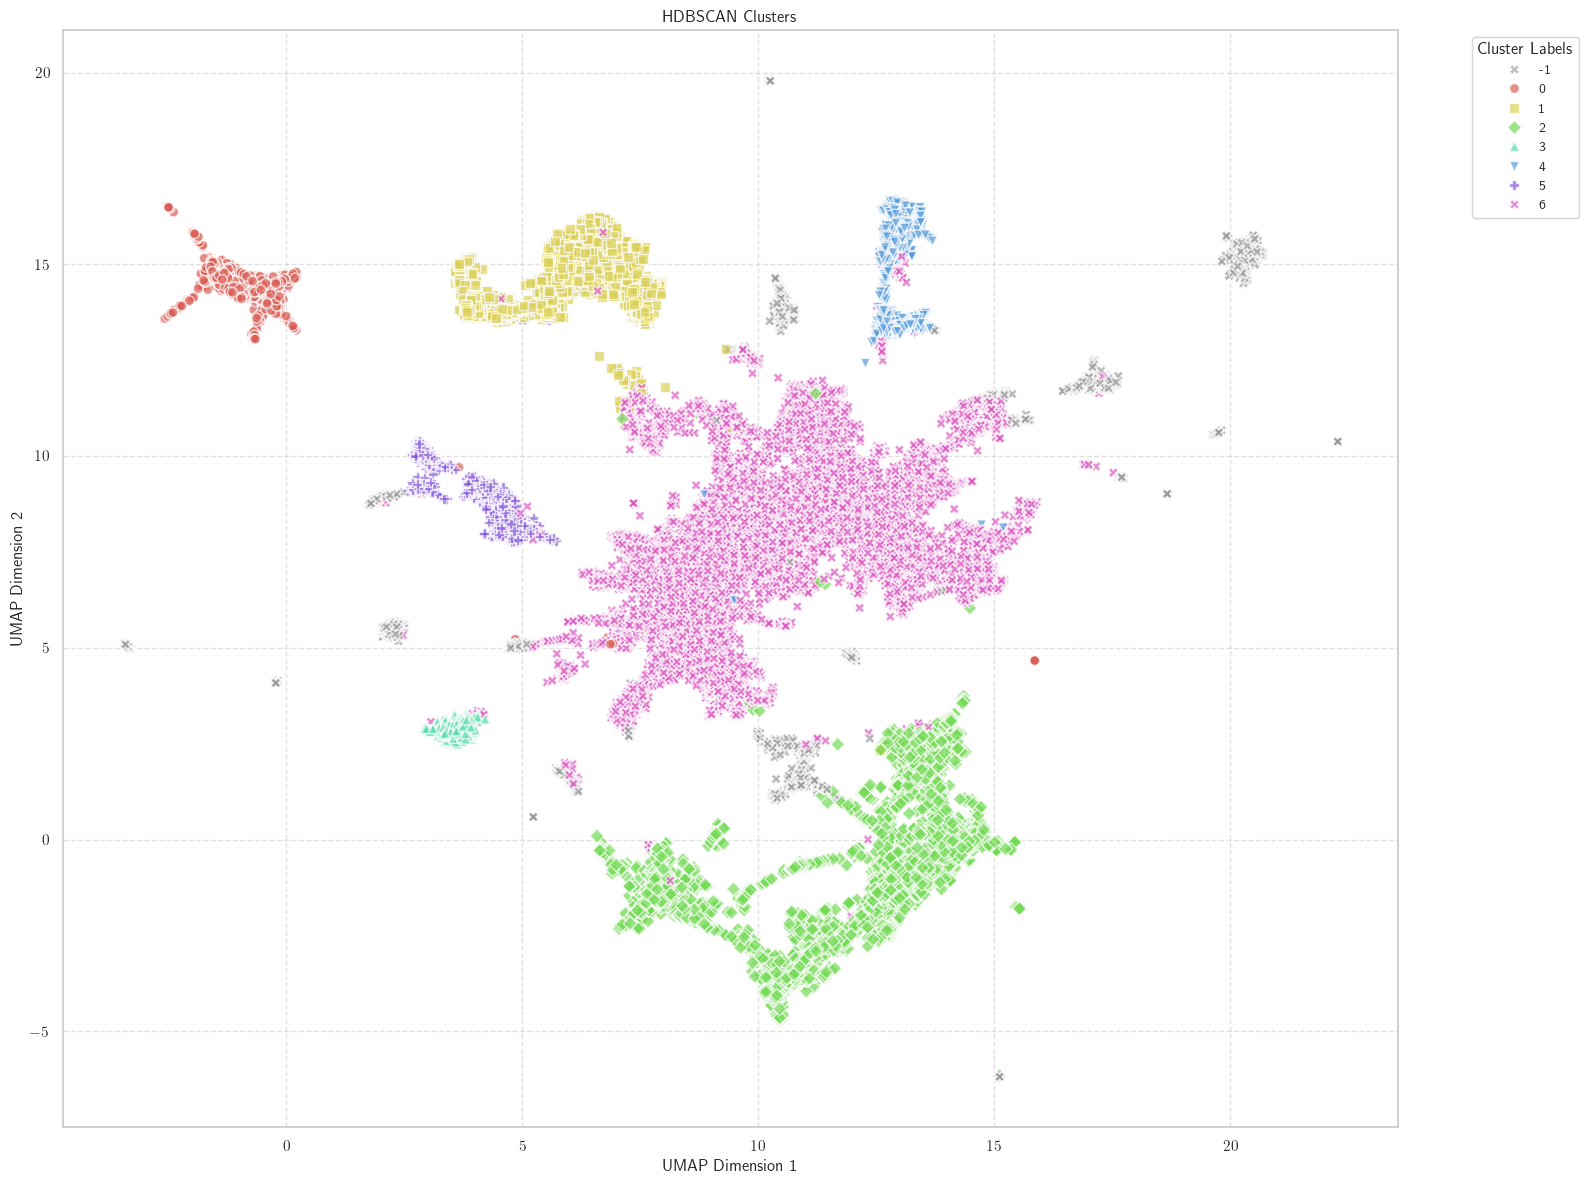

In [18]:
def compute_umap_embedding(features, n_neighbors=30, min_dist=0.1, random_state=42):
    """
    Compute a single 2D UMAP embedding for visualization.

    Args:
        features (numpy.ndarray): The extracted features.
        n_neighbors (int): UMAP parameter, neighborhood size.
        min_dist (float): UMAP parameter, minimum spacing of points.
        random_state (int): Random seed for reproducibility.

    Returns:
        features_2d (numpy.ndarray): 2D embedding of features.
        reducer (umap.UMAP): Fitted UMAP reducer for possible reuse.
    """
    print(f"\nComputing global UMAP embedding (n_neighbors={n_neighbors}, min_dist={min_dist})...")
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, 
                        min_dist=min_dist, random_state=random_state, metric="cosine")
    features_2d = reducer.fit_transform(features)
    return features_2d, reducer


def plot_clusters_on_umap(features_2d, labels, title, save_path=None):
    """
    Plot a precomputed 2D UMAP embedding with cluster-dependent color and style.

    - Each cluster gets a unique color and marker shape.
    - Noise points (-1) are plotted in grey with 'x' markers.
    """
    labels = np.array(labels)

    # Separate noise from valid clusters
    unique_clusters = sorted([c for c in np.unique(labels) if c != -1])
    n_clusters = len(unique_clusters)

    # Define colors and marker styles
    palette = sns.color_palette("hls", n_clusters)
    styles = ["o", "s", "D", "^", "v", "P", "X", "*", "<", ">"]  # reusable

    # Map cluster → color and style
    cluster_to_color = {c: palette[i % len(palette)] for i, c in enumerate(unique_clusters)}
    cluster_to_style = {c: styles[i % len(styles)] for i, c in enumerate(unique_clusters)}

    # Noise cluster
    cluster_to_color[-1] = (0.6, 0.6, 0.6)  # grey
    cluster_to_style[-1] = "X"

    # Build dataframe for seaborn
    plot_df = pd.DataFrame({
        "UMAP1": features_2d[:, 0],
        "UMAP2": features_2d[:, 1],
        "Cluster": labels
    })

    plt.figure(figsize=(16, 12))
    sns.scatterplot(
        data=plot_df,
        x="UMAP1", y="UMAP2",
        hue="Cluster",
        style="Cluster",
        palette=cluster_to_color,
        markers=cluster_to_style,
        s=50,
        alpha=0.7,
        linewidth=1.0
    )

    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.legend(title='Cluster Labels', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches="tight", transparent=False)
        tqdm.write(f"✅ Saved: {save_path}")
    plt.show()
    plt.close()



# Compute UMAP once
features_2d, reducer = compute_umap_embedding(norm_features, n_neighbors=30, min_dist=0.1)

# Plot all clustering results on the same UMAP
plot_clusters_on_umap(features_2d, labels_dict[('Exploratory UMAP','KMeans (Known K)')],
                      title="KMeans (Known K) Clusters",
                      save_path=os.path.join(save_loc, "UMAP_KMeans_known_k.pdf"))

plot_clusters_on_umap(features_2d, labels_dict[('Exploratory UMAP','KMeans (Unknown K)')],
                      title="KMeans (Unknown K) Clusters",
                      save_path=os.path.join(save_loc, "UMAP_KMeans_unknown_k.pdf"))

plot_clusters_on_umap(features_2d, labels_dict[('Exploratory UMAP','Bayesian GMM')],
                      title="Bayesian Gaussian Mixture Model Clusters",
                      save_path=os.path.join(save_loc, "UMAP_BGMM.pdf"))

plot_clusters_on_umap(features_2d, labels_dict[('Exploratory UMAP','HDBSCAN')],
                      title="HDBSCAN Clusters",
                      save_path=os.path.join(save_loc, "UMAP_HDBSCAN.pdf"))












MORPHOLGICAL DIsparity


The Below code computes the feature vector-based diversity using the effective ranks and the varaition of the feature vectors. 

📊 Starting morphology report for dataset 'Diverse Fossils' with 59244 samples and 1024 features
✅ Pairwise distances computed: mean=0.8301, std=0.1408
✅ Effective rank computed: 197.3126
Results saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/morphology_report.csv
Histogram computed from 5000 subsampled points (out of 59244)
Pairwise distance histogram saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/dist_hist.pdf


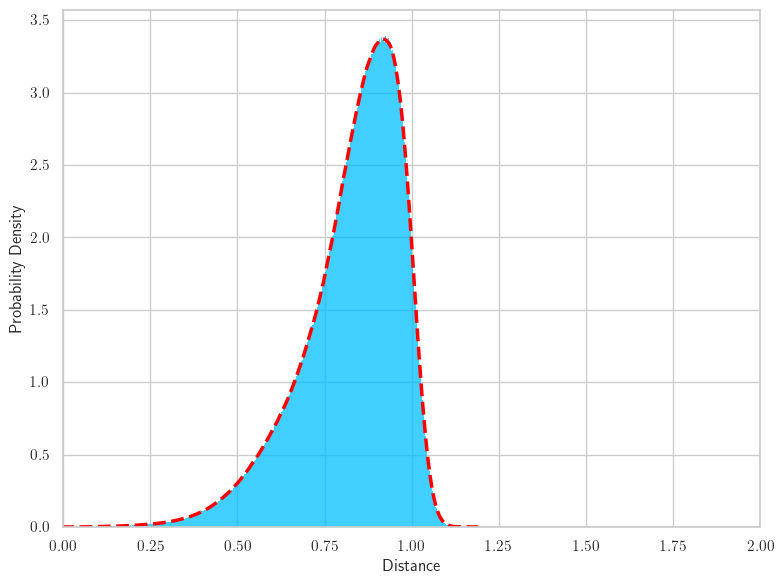

LaTeX table saved to /Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/diverse_paper_oct_facebook_dinov3-vitl16-pretrain-lvd1689m/morphology_report.tex

=== Morphology Diversity Report ===
Dataset                       : Diverse Fossils
n_samples                     : 59244
n_features                    : 1024
n_pca_used                    : None
metric                        : cosine
mean_pairwise_distance        : 0.8301
std_pairwise_distance         : 0.1408
mean_centroid_distance        : 0.5877594947814941
std_centroid_distance         : 0.15632018446922302
variance_sum                  : 0.8300663232803345
effective_rank                : 197.3126

CPU times: user 13min 50s, sys: 12.4 s, total: 14min 3s
Wall time: 14min 9s


{'Dataset': 'Diverse Fossils',
 'n_samples': 59244,
 'n_features': 1024,
 'n_pca_used': None,
 'metric': 'cosine',
 'mean_pairwise_distance': np.float64(0.8300717577050818),
 'std_pairwise_distance': np.float64(0.140757156494889),
 'mean_centroid_distance': np.float32(0.5877595),
 'std_centroid_distance': np.float32(0.15632018),
 'variance_sum': np.float32(0.8300663),
 'effective_rank': 197.31256103515625}

In [19]:
%%time
def morphology_report(
    features,
    dataset_name="Dataset1",
    metric='euclidean',
    n_pca=None,
    save_path=None,
    save_tex=None,
    plot_pairwise_distances=False,
    distance_hist_path=None
):
    """
    Generate a morphology-style disparity report with metrics suitable for high-dimensional comparisons.

    Metrics include:
        - Mean and std. of pairwise distances
        - Mean and std. of distances to the global centroid
        - Total variance (optionally reduced with PCA)
        - Effective rank (entropy-based measure of variance spectrum)

    Notes:
        - Pairwise distances depend on the chosen metric (cosine ∈ [0,2]).
        - Effective rank is a Shannon entropy measure of covariance spectrum,
          ranging between 1 (low diversity) and n_features (maximal diversity).

    Parameters
    ----------
    features : ndarray, shape (n_samples, n_features)
        Feature vectors representing specimens.
    dataset_name : str
        Name of the dataset (for reporting).
    metric : str
        Distance metric for pairwise calculations.
    n_pca : int or None
        Optional PCA dimension for variance calculations.
    save_path : str or None
        CSV or JSON path to save results.
    save_tex : str or None
        LaTeX path to save results.
    plot_pairwise_distances : bool
        Whether to plot pairwise distance histogram.
    distance_hist_path : str or None
        Path to save histogram.

    Returns
    -------
    results : dict
        Computed metrics.
    """
    features = np.asarray(features)
    n_samples, n_features = features.shape

    if n_samples < 2:
        raise ValueError("At least 2 samples required to compute pairwise distances.")

    tqdm.write(f"📊 Starting morphology report for dataset '{dataset_name}' with {n_samples} samples and {n_features} features")


    # --- Pairwise distances ---
    upper_tri = pdist(features, metric=metric)
    mean_pw_dist = upper_tri.mean()
    std_pw_dist = upper_tri.std()

    tqdm.write(f"✅ Pairwise distances computed: mean={mean_pw_dist:.4f}, std={std_pw_dist:.4f}")


    # --- Centroid distances ---
    centroid = features.mean(axis=0, keepdims=True)
    if metric == 'cosine':
        centroid = normalize(centroid, axis=1)

    dists_to_centroid = pairwise_distances(features, centroid, metric=metric).flatten()
    mean_centroid_dist = dists_to_centroid.mean()
    std_centroid_dist = dists_to_centroid.std()

    # --- PCA transformation (optional) ---
    if n_pca is not None and n_pca < n_features:
        pca = PCA(n_components=n_pca)
        pcs = pca.fit_transform(features)
    else:
        pcs = features

    # --- Variance sum ---
    
    var_per_feature = np.var(pcs, axis=0, ddof=1)
    #print(var_per_feature.shape)   should be (n_features,)
    variance_sum = np.sum(var_per_feature)

    # --- Effective rank ---
    ellipsoid_effective_rank = None
    try:
        lw = LedoitWolf().fit(pcs)
        cov = lw.covariance_
        evals = np.linalg.eigvalsh(cov)
        p = np.clip(evals, a_min=0, a_max=None)
        p /= p.sum()
        ellipsoid_effective_rank = float(np.exp(-np.sum(p * np.log(p + 1e-30))))
        tqdm.write(f"✅ Effective rank computed: {ellipsoid_effective_rank:.4f}")
    except Exception as e:
        print(f"⚠️ Effective rank could not be computed: {e}")
        ellipsoid_effective_rank = None

    # --- Prepare results dict ---
    results = {
        "Dataset": dataset_name,
        "n_samples": n_samples,
        "n_features": n_features,
        "n_pca_used": pcs.shape[1] if n_pca else None,
        "metric": metric,
        "mean_pairwise_distance": mean_pw_dist,
        "std_pairwise_distance": std_pw_dist,
        "mean_centroid_distance": mean_centroid_dist,
        "std_centroid_distance": std_centroid_dist,
        "variance_sum": variance_sum,
        "effective_rank": ellipsoid_effective_rank
    }

    # --- Save CSV/JSON ---
    if save_path is not None:
        df = pd.DataFrame([results])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if os.path.exists(save_path):
            print(f"⚠️ Overwriting existing file: {save_path}")
        if save_path.lower().endswith(".csv"):
            df.to_csv(save_path, index=False)
        elif save_path.lower().endswith(".json"):
            df.to_json(save_path, orient="records", indent=2)
        else:
            raise ValueError("Save path must end with .csv or .json")
        print(f"Results saved to {save_path}")

    # --- Optional pairwise distance histogram ---
    if plot_pairwise_distances:
        max_hist_samples = 5000
        if n_samples > max_hist_samples:
            rng = np.random.default_rng(42)
            idx = rng.choice(n_samples, size=max_hist_samples, replace=False)
            subsampled_features = features[idx]
            upper_tri_for_hist = pdist(subsampled_features, metric=metric)
            print(f"Histogram computed from {max_hist_samples} subsampled points (out of {n_samples})")
        else:
            upper_tri_for_hist = upper_tri

        plt.figure(figsize=(8, 6))
        sns.histplot(upper_tri_for_hist, bins='auto', stat="density", color="deepskyblue", edgecolor='white', linewidth=0.0)
        sns.kdeplot(upper_tri_for_hist, color='red', linewidth=2.5, linestyle='--')
        #plt.title(f"Histogram of Pairwise Distances ({metric})")
        plt.xlabel("Distance")
        if metric == 'cosine':
            plt.xlim(0, 2)
        plt.ylabel("Probability Density")
        plt.tight_layout()
        if distance_hist_path is not None:
            os.makedirs(os.path.dirname(distance_hist_path), exist_ok=True)
            plt.savefig(distance_hist_path, dpi=300, bbox_inches='tight')
            print(f"Pairwise distance histogram saved to {distance_hist_path}")
        plt.show()

    # --- Save LaTeX ---
    if save_tex is not None:
        df_fmt = pd.DataFrame([results])
        for col in df_fmt.columns:
            if isinstance(df_fmt[col].iloc[0], (float, np.floating)):
                df_fmt[col] = df_fmt[col].apply(lambda x: f"{x:.4f}" if x is not None else "NA")
        df_fmt.columns = [c.replace("_", "") for c in df_fmt.columns]
        latex_body = df_fmt.to_latex(index=False, escape=False)
        latex_full = (
            "\\begin{table}[h]\n"
            "\\centering\n"
            "\\caption{Morphological diversity metrics.}\n"
            "\\resizebox{\\textwidth}{!}{%\n"
            "\\begin{tabular}{lrrrrrrrr}\n"
            "\\toprule\n"
            + latex_body.splitlines()[2] + "\n"
            "\\midrule\n"
            + "\n".join(latex_body.splitlines()[3:-1]) + "\n"
            "\\bottomrule\n"
            "\\end{tabular}}\n"
            "\\end{table}\n"
        )
        os.makedirs(os.path.dirname(save_tex), exist_ok=True)
        with open(save_tex, "w") as f:
            f.write(latex_full)
        print(f"LaTeX table saved to {save_tex}")

    # --- Print summary ---
    print("\n=== Morphology Diversity Report ===")
    for k, v in results.items():
        if isinstance(v, float):
            print(f"{k:30s}: {v:.4f}")
        else:
            print(f"{k:30s}: {v}")
    print("====================================\n")

    return results


# --- Example usage ---
morphology_report(
   norm_features,
    metric='cosine',
    n_pca=None,
    save_path=os.path.join(save_loc, "morphology_report.csv"),
    save_tex=os.path.join(save_loc, "morphology_report.tex"),
    plot_pairwise_distances=True,
    distance_hist_path=os.path.join(save_loc, "dist_hist.pdf"),
    dataset_name=dataset_name
)
